In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import logging
import seaborn as sns
import numpy as np
import cmdstanpy
import json

from baynes.plotter import FitPlotter
from baynes.toyMC import SpectraSampler
from baynes.analysis import standard_analysis, multithreaded_run, dict_to_json
from baynes.probability import HoSpectrum, hdi, ptolemy, allowed_beta
from baynes.model_utils import get_model
from numba import njit, prange

from sympy import symbols, sin, diff, erf, exp, sqrt, Piecewise, And
from sympy.utilities.lambdify import lambdify
from scipy.special import gamma
from scipy.constants import elementary_charge, hbar, c, electron_mass
from scipy import integrate
import math
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 15

cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
coeffs = np.loadtxt("parameters.dat")[:,1:]

from scipy.constants import hbar, c

m_nu = 0.05
me = 510998.95
mT = 931.49410242e6*3.01604928;
mhe3 = 931.49410242e6*3.0160293;
mhe = mhe3 - me + 24.6
Q = mT - mhe - me;
Krec = 3.44;
K0 = Q-Krec

QT = K0-0.2
A = 3.57e8

g_to_ev = 5.6095883571872E+32


In [3]:
@njit(parallel=False)
def ptolemyint(E, coeffs, m_nu, Q=18589.8):
    """Compute the b-decay spectrum of tritium in graphene."""
    y = 0
    me = 510998.95
    mhe3 = 931.49410242e6*3.0160293
    lambda_val = 4.21e-5
    eps0 = 5.76
    Gf = 1.1663787e-23
    Vud = 0.97373
    gsq = (Gf*Vud)**2 * (1+(1.25*1.65)**2)
    NH3=1/1.66054e-24/3.01604928

    const_discrspe=NH3*gsq*lambda_val**2/(4 * np.pi**3 * 6.582119e-16)
    const_contspe=NH3*gsq*lambda_val/(2 * np.pi**(7./2.) * 6.582119e-16)


    i_disc = lambda_val / (2 * np.pi**3)
    pb = np.sqrt(E**2 + 2 * E * me)

    for k in range(64):
        Qn = Q - coeffs[k][0]
        pn = coeffs[k][1]
        an = coeffs[k][2]
        bn = coeffs[k][3]
        cn = coeffs[k][4]
        E_nu = Qn - E
        if E_nu >= m_nu:
            xb = (pb - pn) / pn
            y += (
                const_discrspe
                * pb
                * (E + me)
                * np.sqrt(E_nu**2 - m_nu**2)
                * E_nu
                * (an + xb * lambda_val * pn * (2 * bn - lambda_val * pn * cn))
            )

    i_cont = 1 / (np.pi ** (7. / 2.))
    QKE = Q - E - eps0
    if QKE >= m_nu:
        b = -pb + np.sqrt(2 * mhe3 * (QKE - m_nu))
        bl = b * lambda_val
        pl = pb * lambda_val
        expbl = np.exp(-(bl**2))
        exppl = np.exp(-(pl**2))
        erfplbl = math.erf(pl) + math.erf(bl)
        pb2_2mhe3 = pb ** 2 / (2 * mhe3)
        kinf2 = np.sqrt(1 - (m_nu / (4.0 + QKE - pb2_2mhe3)) ** 2)
        I0 = (
            np.sqrt(np.pi)
            / (2 * lambda_val)
            * pb
            * (QKE - pb2_2mhe3) ** 2
            * erfplbl
        )
        I1 = (
            1
            / (2 * lambda_val**2)
            * (QKE - pb2_2mhe3)
            * (QKE - 5.0 * pb2_2mhe3)
            * (exppl - expbl)
        )
        I2 = (
            1
            / (4 * lambda_val**3)
            * ((5.0 * pb2_2mhe3 - 3.0 * QKE) * pb / mhe3)
            * (-2 * pl * exppl - 2 * bl * expbl + np.sqrt(np.pi) * erfplbl)
        )
        I3 = (
            1
            / (2 * lambda_val**4)
            * ((5.0 * pb2_2mhe3 - QKE) / mhe3)
            * (exppl * (1 + pl**2) - expbl * (1 + bl**2))
        )
        I4 = (
            5
            * pb
            / (32 * mhe3**2 * lambda_val**5)
            * (
                -expbl * (6 * bl + 4 * bl**3)
                - exppl * (6.0 * pl + 4 * pl**3)
                + 3 * np.sqrt(np.pi) * erfplbl
            )
        )
        I5 = (
            1
            / (8 * mhe3**2 * lambda_val**6)
            * (
                exppl * (2 + 2 * pl**2 + pl**4)
                - expbl * (2.0 + 2.0 * bl**2 + bl**4)
            )
        )
        y += const_contspe * (E + me) * kinf2 * (I0 + I1 + I2 + I3 + I4 + I5)

    #norm = lambda_val * gsq / (2*mhe3)

    return y



def allowed_betasy():
    E = symbols("E")
    m_nu, Q = symbols("m_nu, Q")
    me = 510998.95
    p = sqrt(E**2+2*E*me)
    alpha = 1/137
    beta = p/(E+me)
    eta = 2*np.pi*alpha/beta
    F = eta * (1.002037 - 0.001427 * beta)/(1-exp(-eta))
    return Piecewise((F*p*(E+me)*(Q-E)*sqrt((Q - E) ** 2 - m_nu**2), And(Q-E>=m_nu, m_nu>=0, Q>=0)),(0, True))+1e-8

def ptolemysym(coeffs):
    """Compute the b-decay spectrum of tritium in graphene."""
    E = symbols("E")
    y = symbols("y")
    m_nu, Q = symbols("m_nu, Q")
    me = 510998.95
    mhe3 = 2809413505.67592
    lambda_val = 4.21e-5
    eps0 = 5.76

    i_disc = lambda_val / (2 * np.pi**3)
    pb = sqrt(E**2 + 2 * E * me)

    y = 0
    for k in range(64):
        Qn = Q - coeffs[k][0]
        pn = coeffs[k][1]
        an = coeffs[k][2]
        bn = coeffs[k][3]
        cn = coeffs[k][4]
        E_nu = Qn - E
        xb = (pb - pn) / pn
        y += Piecewise((i_disc * pb * (E + me) * sqrt(E_nu**2 -m_nu**2) * E_nu * (an + xb * lambda_val * pn * (2 * bn - lambda_val * pn * cn)), E_nu>=m_nu), (0, True))

    i_cont = 1 / (np.pi**(7 / 2))
    QKE = Q - E - eps0
    b = -pb + sqrt(2 * mhe3 * (QKE - m_nu))
    bl = b * lambda_val
    pl = pb * lambda_val
    expbl = exp(-bl**2)
    exppl = exp(-pl**2)
    erfplbl = erf(pl) + erf(bl)
    pb2_2mhe3 = pb**2 / (2 * mhe3)
    kinf2 = sqrt(1 - (m_nu / (4.0 + QKE - pb2_2mhe3))**2)
    I0 = sqrt(np.pi) / (2 * lambda_val) * pb * (QKE - pb2_2mhe3)**2 * erfplbl
    I1 = 1 / (2 * lambda_val**2) * (QKE - pb2_2mhe3) * (QKE - 5.0 * pb2_2mhe3) * (exppl - expbl)
    I2 = 1 / (4 * lambda_val**3) * ((5.0 * pb2_2mhe3  - 3.0 * QKE)* pb / mhe3) * (
            -2 * pl * exppl - 2 * bl * expbl + sqrt(np.pi) * erfplbl)
    I3 = 1 / (2 * lambda_val**4) * ((5.0 * pb2_2mhe3 - QKE )/ mhe3) * (
            exppl * (1 + pl**2) - expbl * (1 + bl**2))
    I4 = 5 * pb / (32 * mhe3**2 * lambda_val**5) * (
            -expbl * (6 * bl + 4 * bl**3) - exppl * (6.0 * pl + 4 * pl**3) + 3 * sqrt(np.pi) * erfplbl)
    I5 = 1 / (8 * mhe3**2 * lambda_val**6) * (exppl * (2 + 2 * pl**2 + pl**4) - expbl * (2.0 + 2.0 * bl**2 + bl**4))
    y += Piecewise((i_cont * (E + me) * kinf2 * (I0 + I1 + I2 + I3 + I4 + I5), QKE>=m_nu), (0, True))

    return y

m_nus = symbols("m_nu")
Es = symbols("E")
Qs = symbols("Q")

partial_m_pt = diff(ptolemysym(coeffs), m_nus)
dens_pt = 1/ptolemysym(coeffs) * (partial_m_pt**2)
f_pt = lambdify((Es, m_nus, Qs), dens_pt, "numpy")

partial_Q_pt = diff(ptolemysym(coeffs), Qs)
dens_pt_Q = 1/ptolemysym(coeffs) * (partial_Q_pt**2)
f_pt_Q = lambdify((Es, m_nus, Qs), dens_pt_Q, "numpy")

partial_m_beta = diff(allowed_betasy(), m_nus)
dens_beta = 1/allowed_betasy() * (partial_m_beta**2)
f_beta = lambdify((Es, m_nus, Qs), dens_beta, "numpy")

# TODO
- Preliminare:
    * normalizzazione
    * media di bin vicini
- Sensitivity analitica
- Base:
    * Prior $m_\nu$
    * andamento statistica m=0
    * andamento m=0.3
- Sistematiche:
    * Qs 0.1 per statistica bassa e alta
    * Qs 0.01 per statistica alta
    * FWHM per alta?

Confronto con beta?

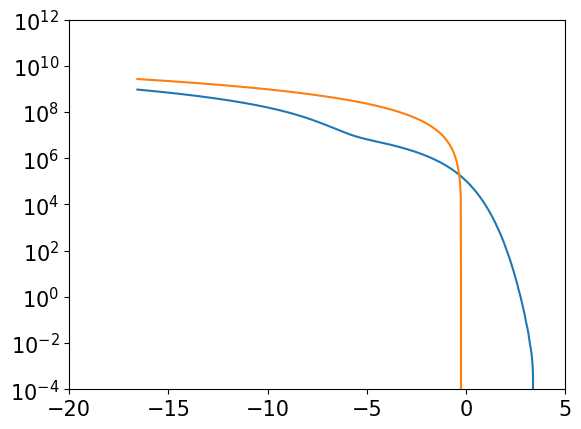

In [9]:
dE = 0.01
E = np.arange(Q-20, Q+5, dE)
y = ptolemy(E, coeffs, m_nu, Q)*1e-3*24*3600*365
plt.plot(E-K0, y)

yt = allowed_beta(E, m_nu, QT)*1e-3*24*3600*365
plt.plot(E-K0, yt)
plt.yscale("log")
plt.ylim(1e-4, 1e12)
plt.xlim(-20, 5)

normM20  = int(np.sum(y)*1e-3*dE)
normT20 = int(np.sum(yt)*1e-3*dE) 
E = np.arange(Q-10, Q+5, dE)
y = ptolemy(E, coeffs, m_nu, Q)*1e-3*24*3600*365
normM10  = int(np.sum(y)*1e-3*dE)




In [14]:
21200000/normM20

6.0112103401891375

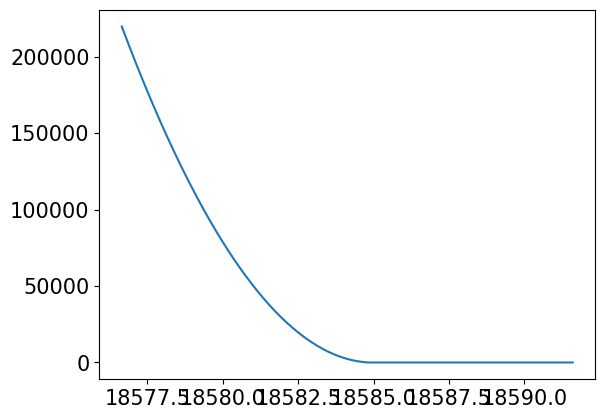

In [37]:
plt.plot(E, allowed_beta(E, 0.2, 18585))

In [6]:
integrate.quad(ptolemyint, Q-20, Q, args = tuple([coeffs, m_nu, Q]))[0]*1e-6*24*3600*365

3518174.5695928275

## Sensitivity function

<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in sqrt
  return (select([less_equal(m_nu, -E + Q),True], [-0.000686321310042043*m_nu*(1077.18092666151 - 7.61199993338816*sqrt(9.78475591779592e-7*E**2 + E))*(-E + Q)*(E + 510998.95)*sqrt(9.78475591779592e-7*E**2 + E)/sqrt(-m_nu**2 + (-E + Q)**2),0], default=nan) + select([less_equal(m_nu, -E + Q - 0.187089018191407),True], [-0.000686321310042043*m_nu*(4641.82423528311 - 32.7582039226147*sqrt(9.78475591779592e-7*E**2 + E))*(E + 510998.95)*sqrt(9.78475591779592e-7*E**2 + E)*(-E + Q - 0.187089018191407)/sqrt(-m_nu**2 + (-E + Q - 0.187089018191407)**2),0], default=nan) + select([less_equal(m_nu, -E + Q - 0.371208495956932),True], [-0.000686321310042043*m_nu*(19925.2254339711 - 140.392620690961*sqrt(9.78475591779592e-7*E**2 + E))*(E + 510998.95)*sqrt(9.78475591779592e-7*E**2 + E)*(-E + Q - 0.371208495956932)/sqrt(-m_nu**2 + (-E + Q - 0.371208495956932)**2),0], default=nan) + select([less_equal(m_nu, -E + Q - 0.552358433296

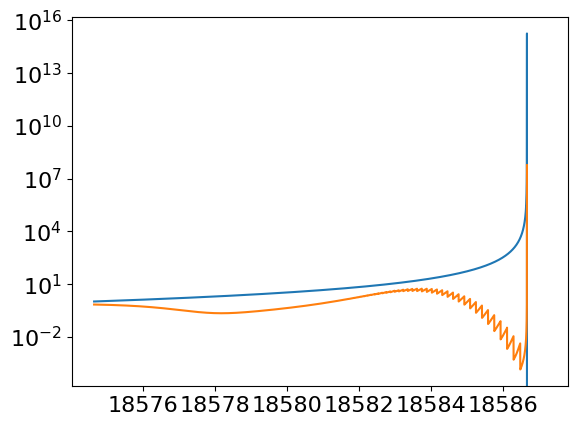

In [9]:
m_nu = 0.0001
E = np.linspace(Q-12, Q+0.5, 5000)

pt_norm = f_pt(18000,m_nu, Q)
beta_norm = f_beta(18000,m_nu, Q)

sp1 = ptolemy(E, coeffs, m_nu, Q)
beta = allowed_beta(E, m_nu, Q)
beta_d = np.array([f_beta(e,m_nu, Q) for e in E])/f_beta(Q-12,m_nu, Q)
pt_d = np.array([f_pt(e, m_nu, Q) for e in E])/f_pt(Q-12, m_nu, Q)

#for m in [0, 0.05, 0.1, 0.5, 1, 2]:
 #   plt.plot(E, ptolemy(E, coeffs, m, Q))
#plt.plot(E, beta/sum(beta))
#plt.plot(E, sp1/sum(sp1))
plt.plot(E, beta_d)
plt.plot(E, pt_d*beta_norm/pt_norm)
plt.yscale("log")


<lambdifygenerated-1>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return (select([less_equal(m_nu, -E + Q),True], [-0.000686321310042043*m_nu*(1077.18092666151 - 7.61199993338816*sqrt(9.78475591779592e-7*E**2 + E))*(-E + Q)*(E + 510998.95)*sqrt(9.78475591779592e-7*E**2 + E)/sqrt(-m_nu**2 + (-E + Q)**2),0], default=nan) + select([less_equal(m_nu, -E + Q - 0.187089018191407),True], [-0.000686321310042043*m_nu*(4641.82423528311 - 32.7582039226147*sqrt(9.78475591779592e-7*E**2 + E))*(E + 510998.95)*sqrt(9.78475591779592e-7*E**2 + E)*(-E + Q - 0.187089018191407)/sqrt(-m_nu**2 + (-E + Q - 0.187089018191407)**2),0], default=nan) + select([less_equal(m_nu, -E + Q - 0.371208495956932),True], [-0.000686321310042043*m_nu*(19925.2254339711 - 140.392620690961*sqrt(9.78475591779592e-7*E**2 + E))*(E + 510998.95)*sqrt(9.78475591779592e-7*E**2 + E)*(-E + Q - 0.371208495956932)/sqrt(-m_nu**2 + (-E + Q - 0.371208495956932)**2),0], default=nan) + select([less_equal(m_nu, -E + Q - 0.55

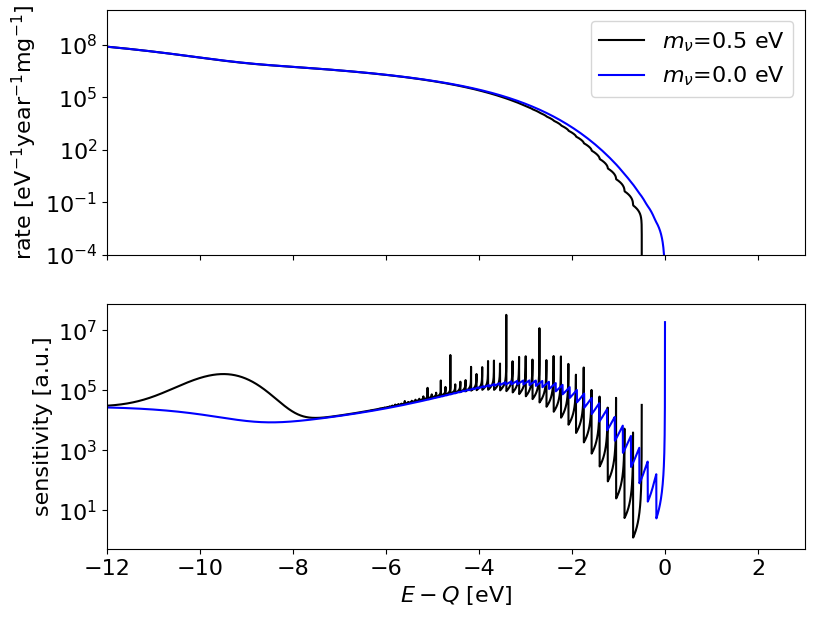

In [10]:
f, ax = plt.subplots(2,1, figsize= (9,7), sharex=True)
colors = ["black", "blue"]
for i, m in enumerate([0.5, 0.00001]):
    spectrum = ptolemy(E, coeffs, m, Q)
    sens = np.array([f_pt(e, m, Q) for e in E])/f_pt(16000, m, Q)

    ax[0].plot(E[:]-Q, spectrum*1e-3*24*3600*365, label=f"$m_\\nu$={round(m, 1)} eV", c=colors[i])
    ax[1].plot(E[:]-Q, sens, c=colors[i])


plt.xlim(-12, 3)
ax[0].set_ylim(1e-4, 1e10)

ax[1].set_yscale("log")
ax[0].set_yscale("log")
ax[1].set_xlabel("$E-Q$ [eV]")
ax[1].set_ylabel("sensitivity [a.u.]")
ax[0].set_ylabel("rate [eV$^{-1}$year$^{-1}$mg$^{-1}$]") 

ax[0].legend()  

# Basic model fit

# numerical

In [88]:
s_sum = SpectraSampler({'$^{163}Ho$': [ptolemy, [coeffs, m, Q], A_T]}, flat_bkg=bkg, FWHM=FWHM, dE=0.001, integrate=False, ROI=[Q-10, Q+1])
sp_sum = s_sum.full_spectrum[s_sum.ROI_idx[0]:s_sum.ROI_idx[1]]
sp = s.full_spectrum[s.ROI_idx[0]:s.ROI_idx[1]]


/tmp/ipykernel_7454/274865719.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(s.ROI_bin_centers,(sp-sp_sum)/sp)


(-0.05, 0.05)

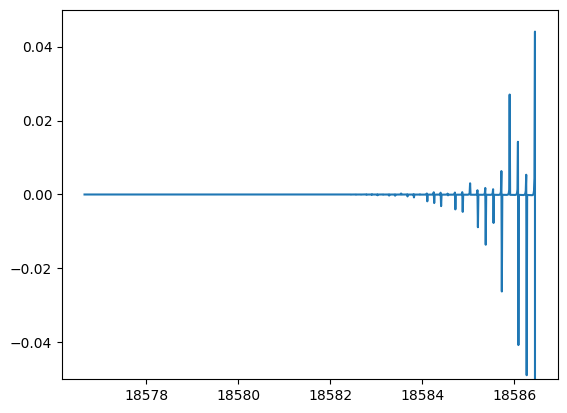

In [59]:
plt.plot(s.ROI_bin_centers,(sp-sp_sum)/sp)
plt.ylim( -0.05, 0.05)

In [89]:
N=10
s_sum2 = SpectraSampler({'$^{163}Ho$': [ptolemy, [coeffs, m, Q], A_T]}, flat_bkg=bkg, FWHM=0.1, dE=N*0.001, integrate=False, ROI=[Q-10, Q+1])
sp_sum2 = s_sum2.full_spectrum[s_sum2.ROI_idx[0]:s_sum2.ROI_idx[1]]

/tmp/ipykernel_7454/4234692682.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(s_sum2.ROI_bin_centers, (np.bincount(np.arange(len(sp_sum))//N, sp_sum)/N-sp_sum2)/sp_sum2)


(-0.1, 0.1)

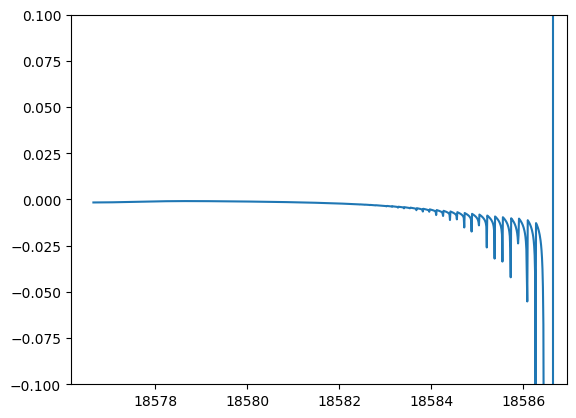

In [90]:
plt.plot(s_sum2.ROI_bin_centers, (np.bincount(np.arange(len(sp_sum))//N, sp_sum)/N-sp_sum2)/sp_sum2)
plt.axvline(Q)
plt.ylim(-0.1, 0.1)

/tmp/ipykernel_6057/1115375732.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(s.ROI_bin_centers, (np.bincount(np.arange(len(sp_sum))//2, sp_sum)/2-s.full_spectrum[s.ROI_idx[0]:s.ROI_idx[1]])/s.full_spectrum[s.ROI_idx[0]:s.ROI_idx[1]])


(-0.01, 0.02)

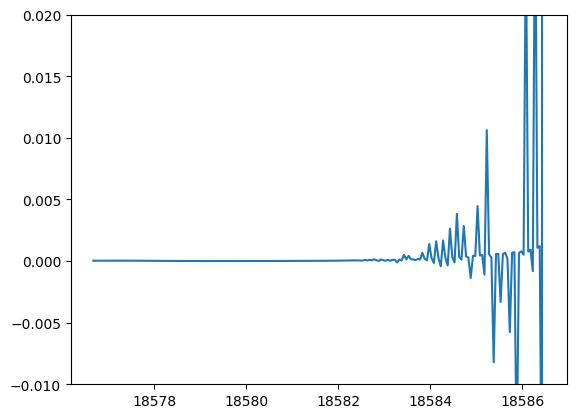

In [52]:
plt.plot(s.ROI_bin_centers, (np.bincount(np.arange(len(sp_sum))//2, sp_sum)/2-s.full_spectrum[s.ROI_idx[0]:s.ROI_idx[1]])/s.full_spectrum[s.ROI_idx[0]:s.ROI_idx[1]])
plt.ylim(-0.01, 0.02)

In [ ]:
plot_pars = ['m_nu', 'Q', "Qs[1]", "Qs[2]", "Qs[62]", "Qs[63]"]
p.pair_grid(parameters=plot_pars)

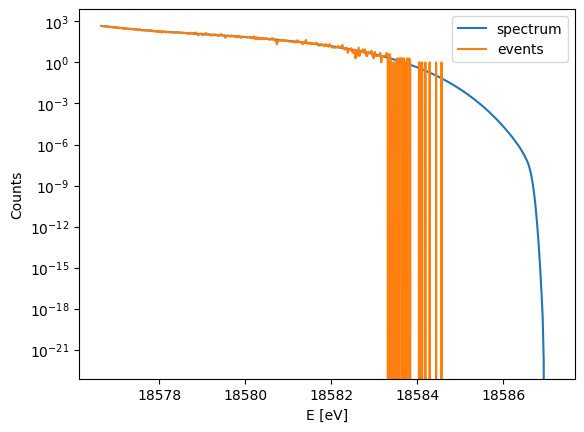

In [62]:
s.n_events = normM10
events = s.sample()[0]
s.plot_events(events)

data={'N_bins': len(events),
      'x': s.ROI_bin_edges,
      "N_ev": s.n_events,
      'counts': events,
      'p_Q': Q,
      'p_std_Q': s_Q,
      'p_FWHM': FWHM,
      'p_std_FWHM': 0.01,
      'm_max':10,
      "coeffs": coeffs,
      "prior":1
}

Found .stan file  /home/pietro/work/TESI/baynes/stan/models/ptolemy/ptolemy_endpoint.stan

 ---- Sampling the priors ---- 


 ---- Prior predictive check ---- 



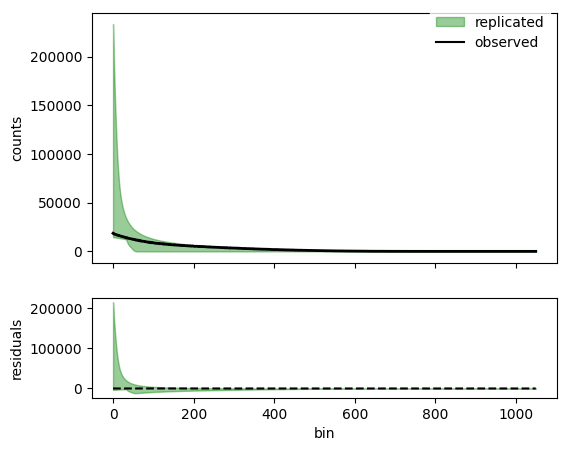


 ---- Prior distributions ---- 



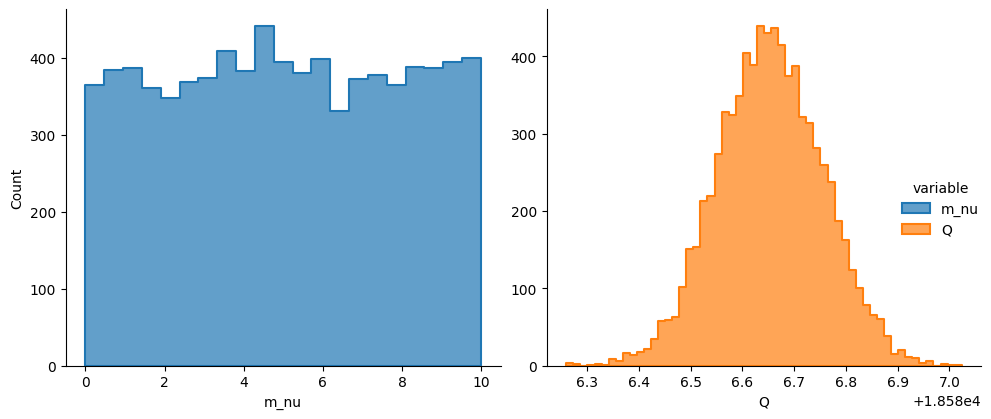


 ---- Fitting the model ---- 



chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

chain 6 |          | 00:00 Status

chain 7 |          | 00:00 Status

chain 8 |          | 00:00 Status

chain 9 |          | 00:00 Status

chain 10 |          | 00:00 Status

chain 11 |          | 00:00 Status

chain 12 |          | 00:00 Status

chain 13 |          | 00:00 Status

chain 14 |          | 00:00 Status

chain 15 |          | 00:00 Status

chain 16 |          | 00:00 Status

/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


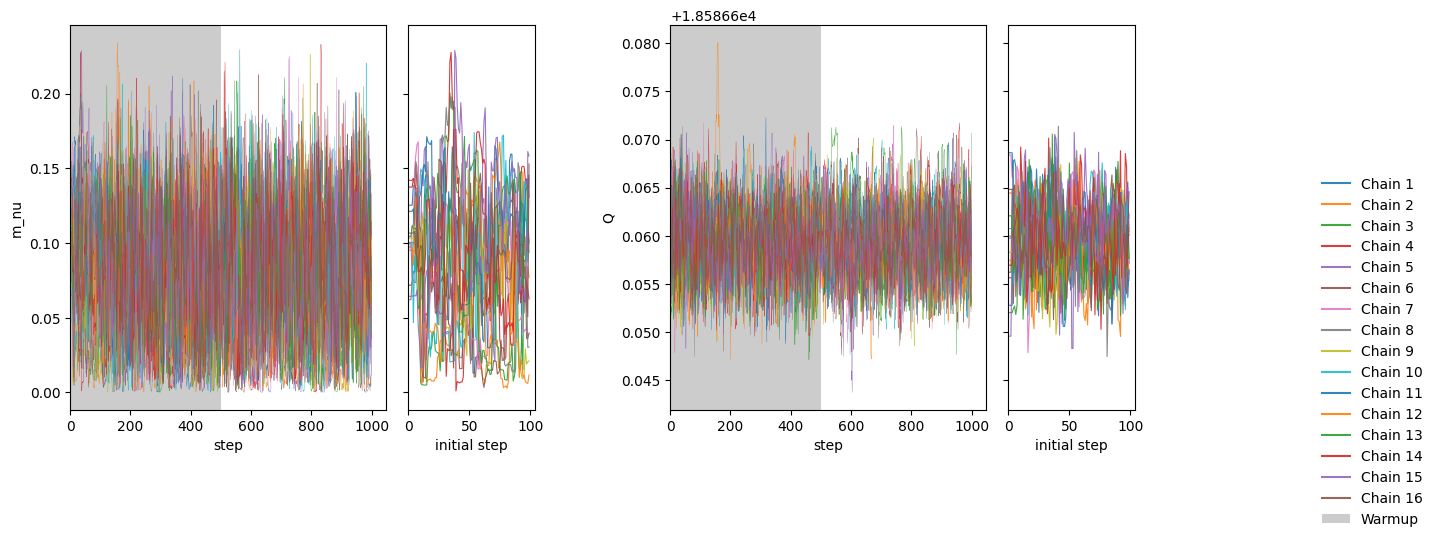


 ---- Posterior predictive check ---- 



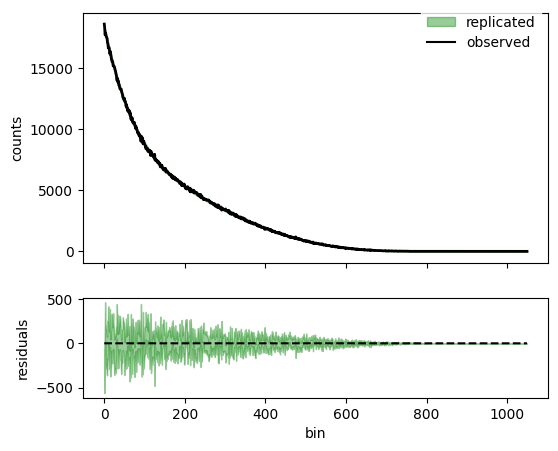


 ---- Posterior distributions ---- 



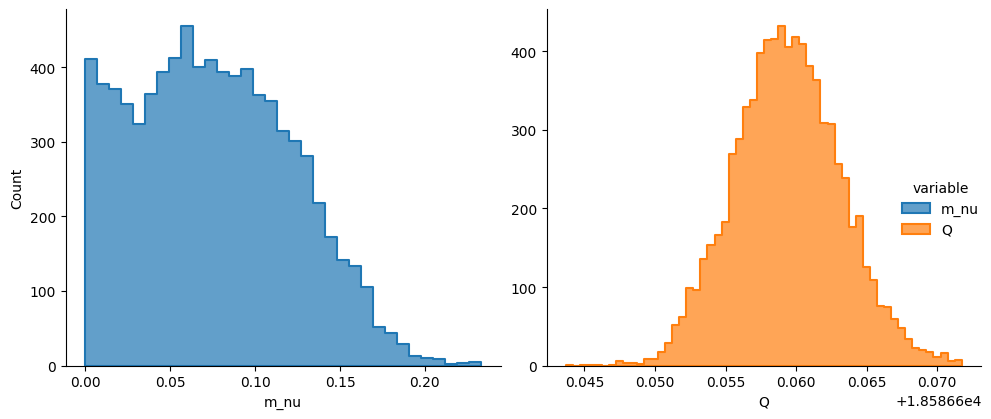


 ---- Prior vs posterior comparison ---- 



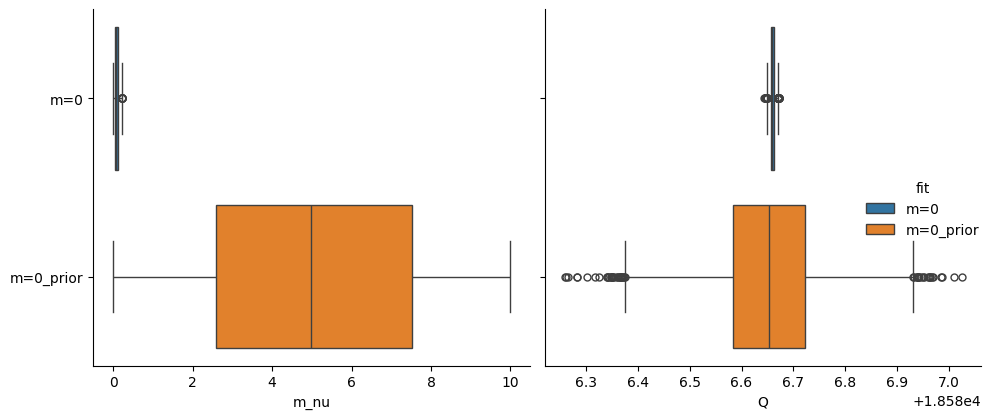

In [14]:
model= get_model("ptolemy_endpoint.stan")

sampler_kwargs={
    'chains': 16,
    'iter_warmup': 500,
    'iter_sampling': 500,
    'save_warmup': True,
    'adapt_delta': 0.9,
    "sig_figs": 10,
    "show_console": False,
    "inits": {"m_red": 0.01, "z": 0}
}

plot_pars = ['m_nu', 'Q']
p = FitPlotter(col_wrap=4)

#fit = model.sample(data, chains=1, fixed_param=True , iter_sampling=4, iter_warmup=1)

model_noQ = get_model("ptolemy_endpoint.stan")
fit_noQs = standard_analysis(model_noQ, data, p, sampler_kwargs, fit_title='m=0', plot_params = plot_pars)

550 67421

 ---- Sampling the priors ---- 


 ---- Prior predictive check ---- 



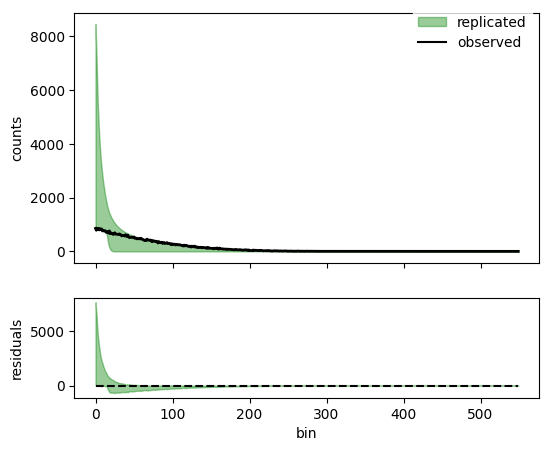


 ---- Prior distributions ---- 



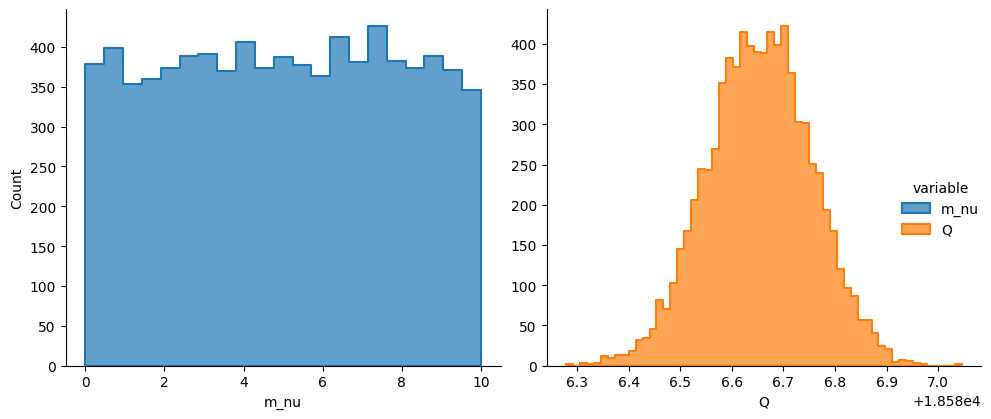


 ---- Fitting the model ---- 



chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

chain 6 |          | 00:00 Status

chain 7 |          | 00:00 Status

chain 8 |          | 00:00 Status

chain 9 |          | 00:00 Status

chain 10 |          | 00:00 Status

chain 11 |          | 00:00 Status

chain 12 |          | 00:00 Status

chain 13 |          | 00:00 Status

chain 14 |          | 00:00 Status

chain 15 |          | 00:00 Status

chain 16 |          | 00:00 Status

/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


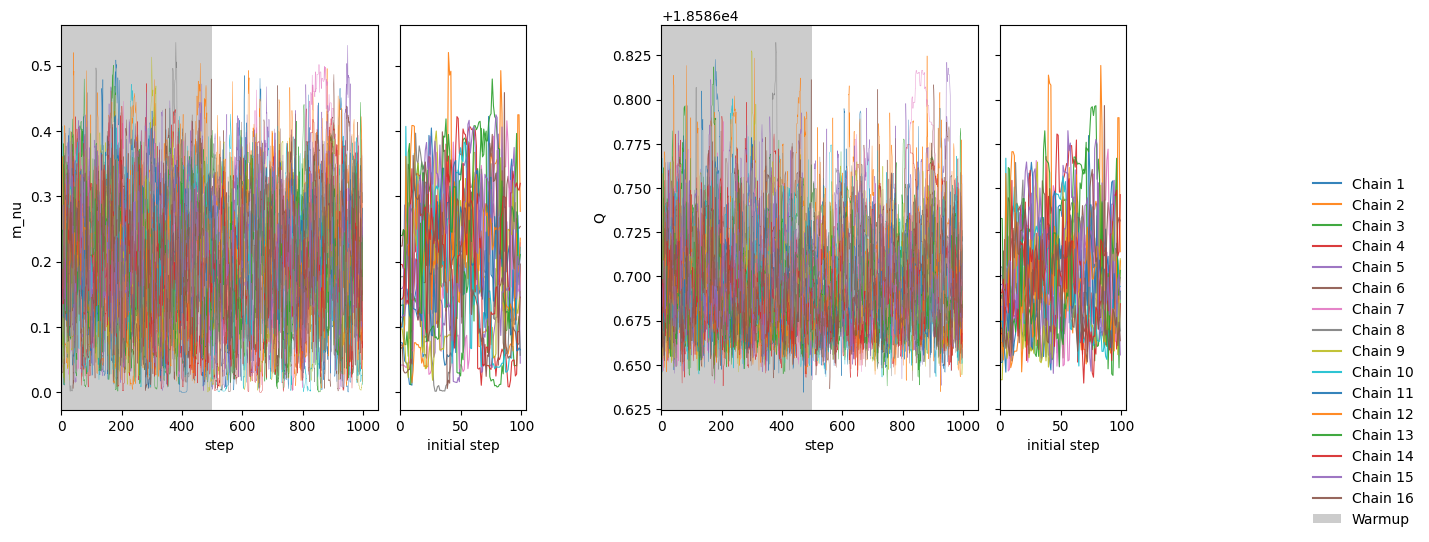


 ---- Posterior predictive check ---- 



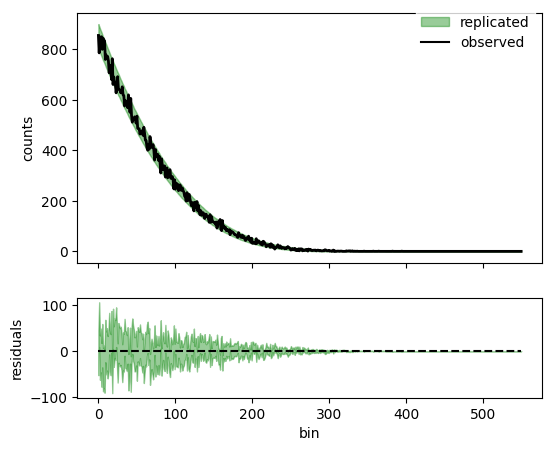


 ---- Posterior distributions ---- 



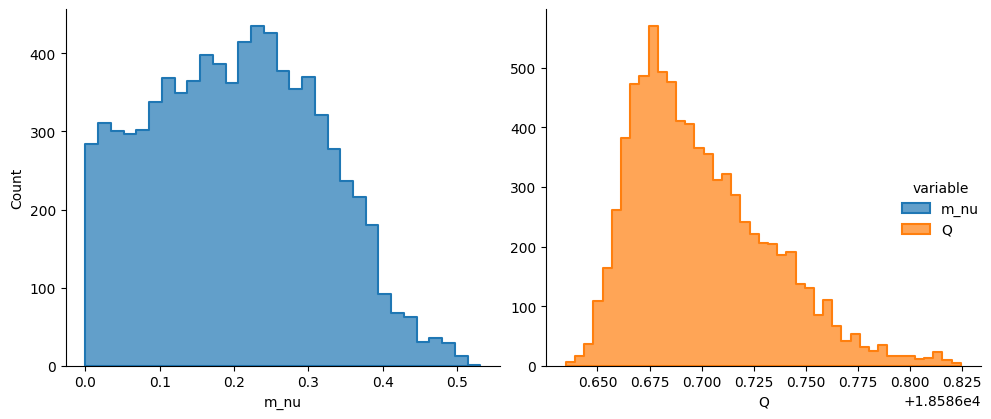


 ---- Prior vs posterior comparison ---- 



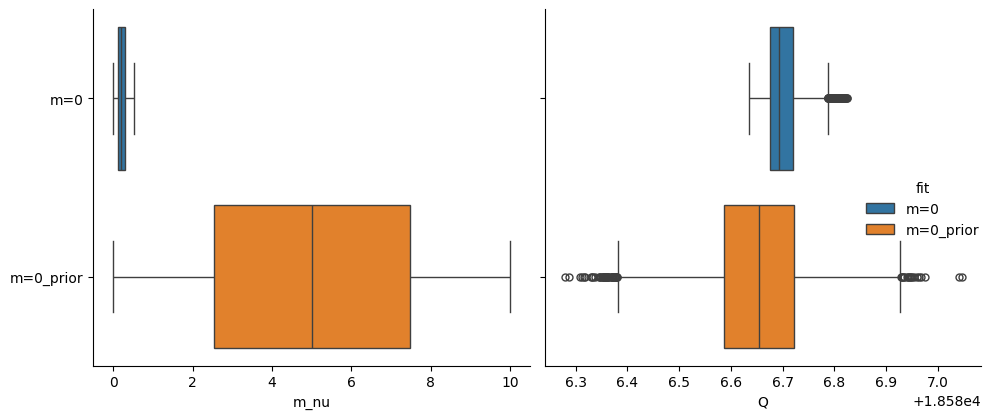

In [29]:

c = events[500:]
Ns = sum(c)
print(len(c), Ns)
data.update({"counts": c,
    "N_bins" : len(s.ROI_bin_edges[500:])-1,
    "x":s.ROI_bin_edges[500:],
    "N_ev": Ns
})

fit = standard_analysis(model, data, p, sampler_kwargs, fit_title='m=0', plot_params = plot_pars)

210 210

 ---- Sampling the priors ---- 


 ---- Prior predictive check ---- 



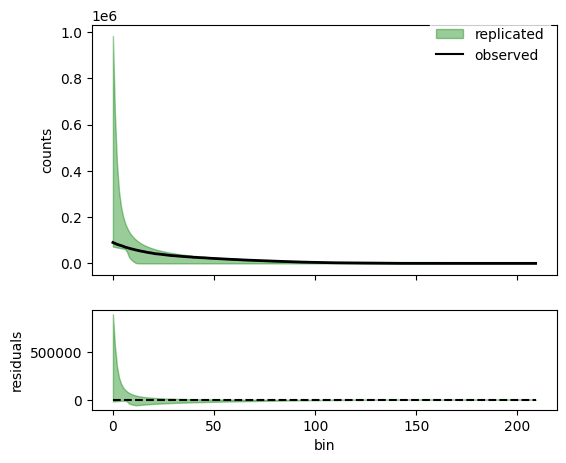


 ---- Prior distributions ---- 



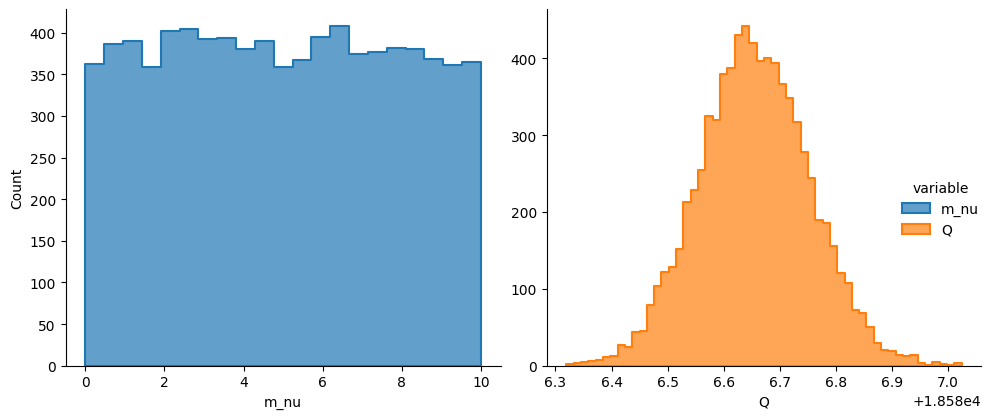


 ---- Fitting the model ---- 



chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

chain 6 |          | 00:00 Status

chain 7 |          | 00:00 Status

chain 8 |          | 00:00 Status

chain 9 |          | 00:00 Status

chain 10 |          | 00:00 Status

chain 11 |          | 00:00 Status

chain 12 |          | 00:00 Status

chain 13 |          | 00:00 Status

chain 14 |          | 00:00 Status

chain 15 |          | 00:00 Status

chain 16 |          | 00:00 Status

/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


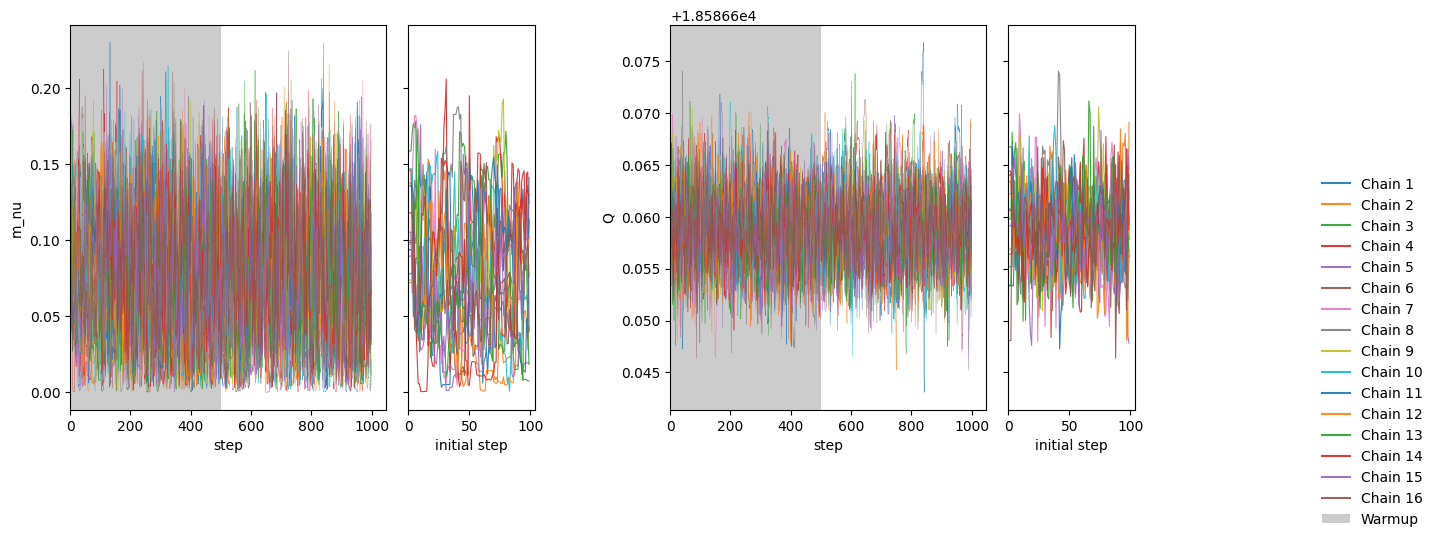


 ---- Posterior predictive check ---- 



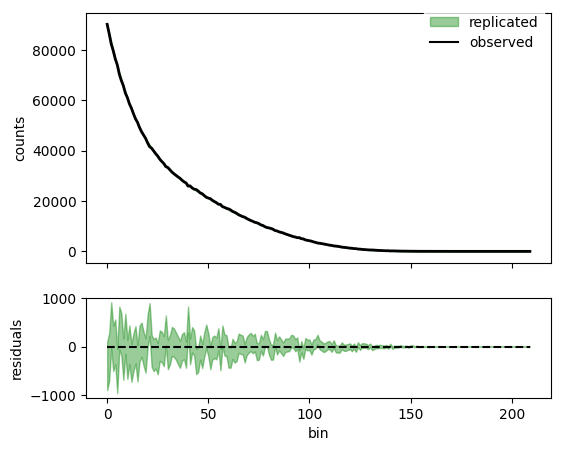


 ---- Posterior distributions ---- 



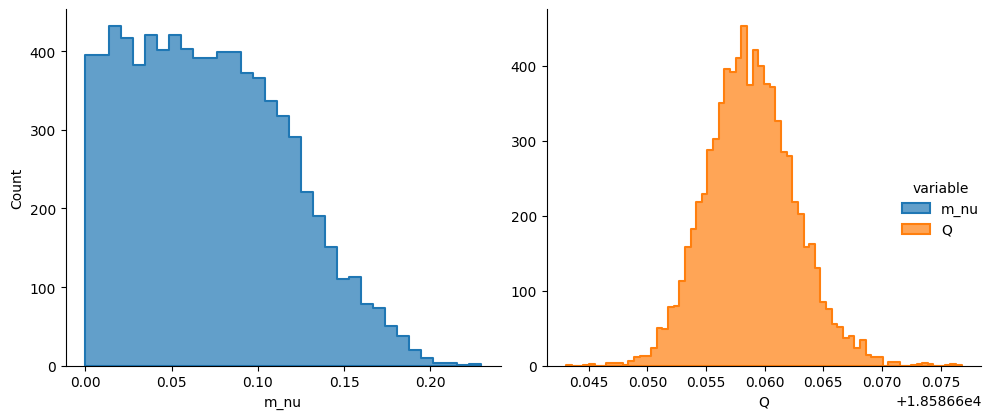


 ---- Prior vs posterior comparison ---- 



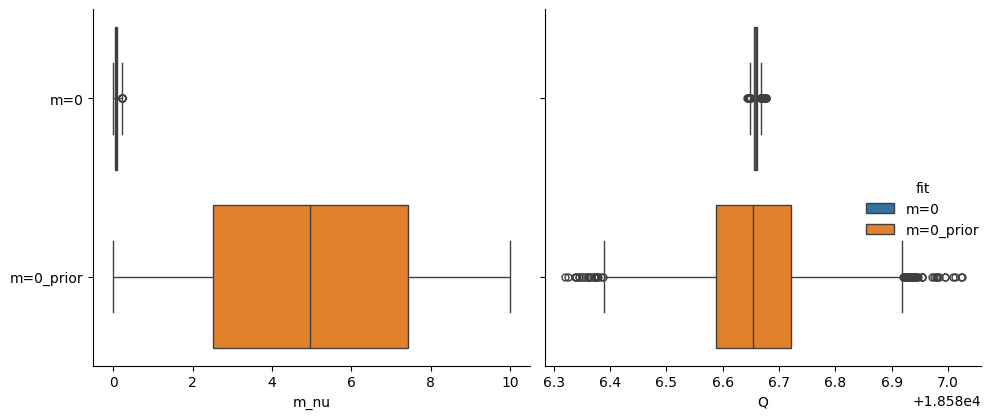

In [22]:
N = 5
c = [int(count) for count in np.bincount(np.arange(len(events))//N, events)]
Ns = int(len(events)/N)
print(len(c), Ns)
data.update({"counts": c,
    "N_bins" : Ns,
    "x":s.ROI_bin_edges[::N]
})

fit = standard_analysis(model, data, p, sampler_kwargs, fit_title='m=0', plot_params = plot_pars)

In [24]:
print(fit_noQs.summary().loc["m_nu"], fit.summary().loc["m_nu"])

Mean          0.075773
MCSE          0.001188
StdDev        0.046133
5%            0.006828
50%           0.073204
95%           0.155485
N_Eff      1507.530000
N_Eff/s       0.527254
R_hat         1.014970
Name: m_nu, dtype: float64 Mean          0.071888
MCSE          0.001127
StdDev        0.045170
5%            0.007027
50%           0.068715
95%           0.152692
N_Eff      1605.510000
N_Eff/s       6.473580
R_hat         1.005950
Name: m_nu, dtype: float64


Found .stan file  /home/pietro/work/TESI/baynes/stan/models/ptolemy/ptolemy_endpoint.stan

 ---- Sampling the priors ---- 


 ---- Prior predictive check ---- 



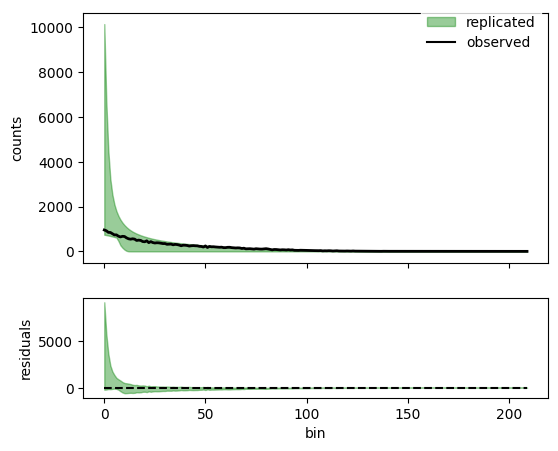


 ---- Prior distributions ---- 



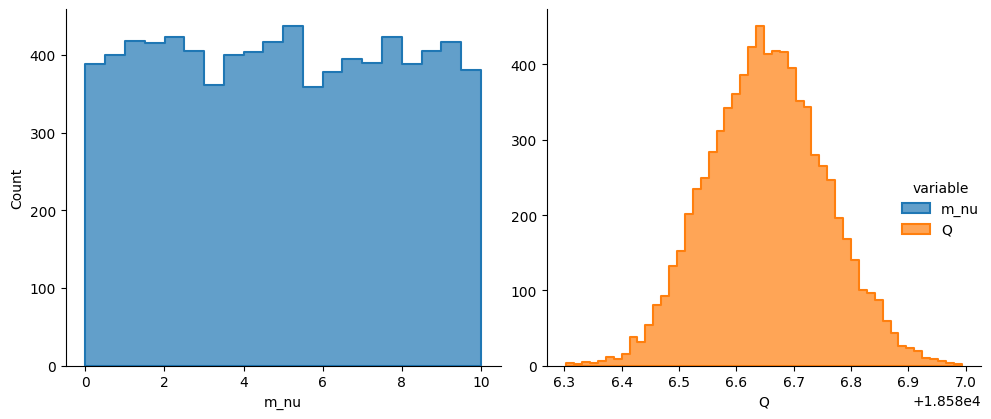


 ---- Fitting the model ---- 



chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

chain 6 |          | 00:00 Status

chain 7 |          | 00:00 Status

chain 8 |          | 00:00 Status

chain 9 |          | 00:00 Status

chain 10 |          | 00:00 Status

chain 11 |          | 00:00 Status

chain 12 |          | 00:00 Status

chain 13 |          | 00:00 Status

chain 14 |          | 00:00 Status

chain 15 |          | 00:00 Status

chain 16 |          | 00:00 Status

/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


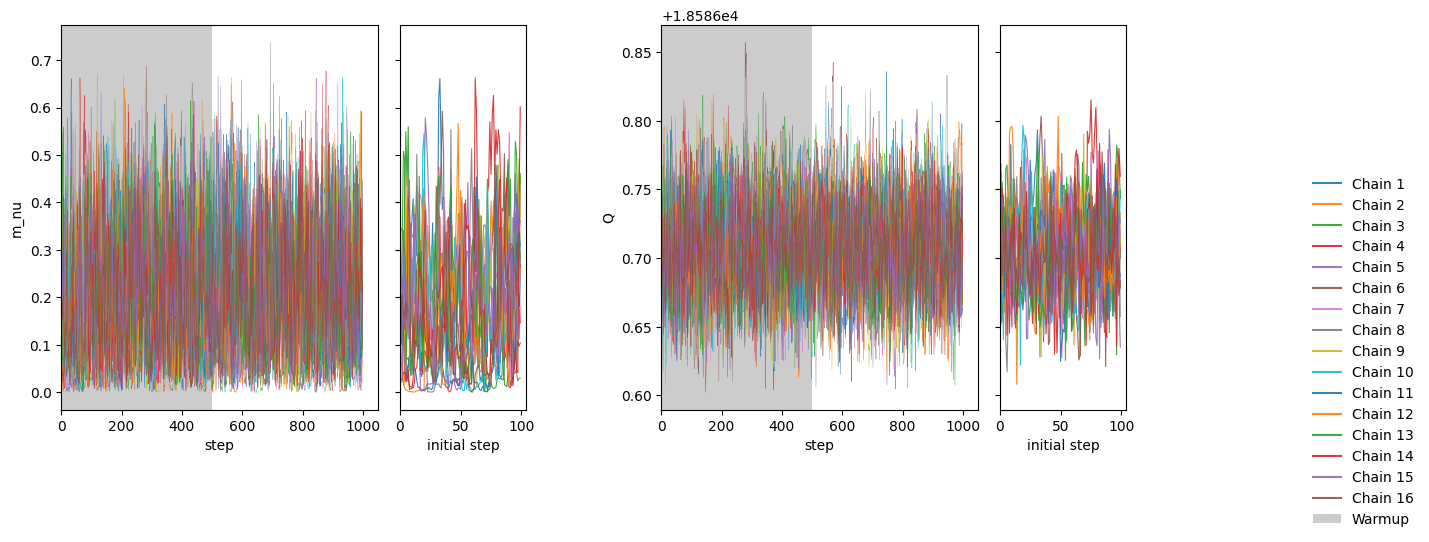


 ---- Posterior predictive check ---- 



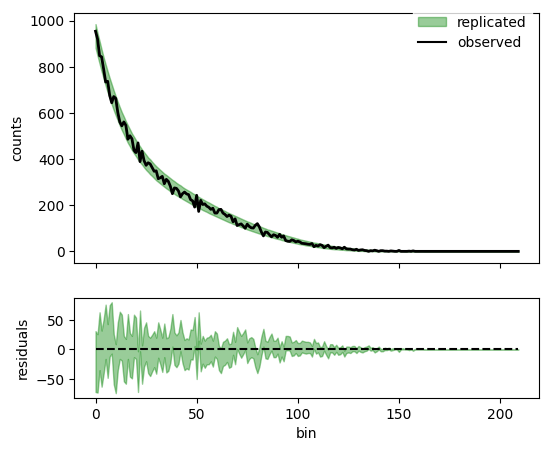


 ---- Posterior distributions ---- 



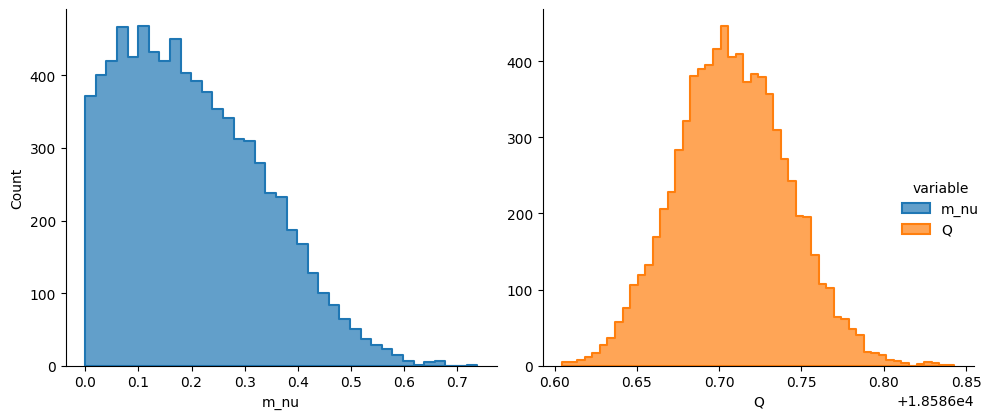


 ---- Prior vs posterior comparison ---- 


 Saving files to  data/allQ/noQs_1_005
Dictionary saved to data/allQ/noQs_1_005/data.json


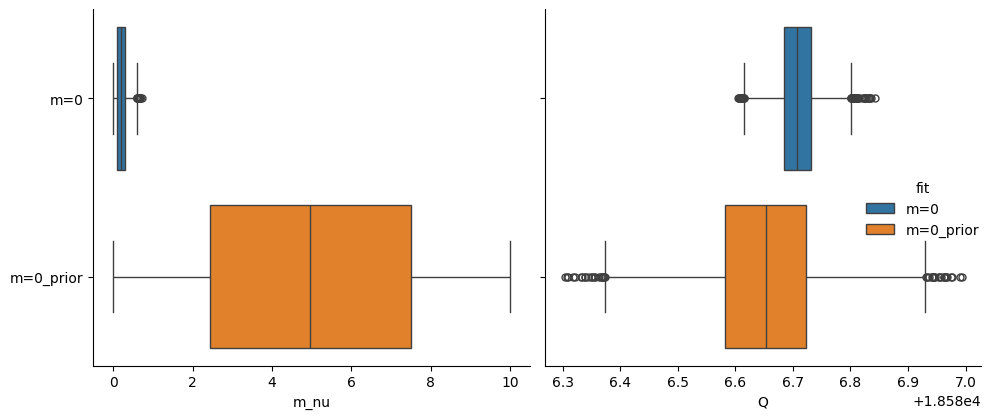

In [6]:
model_noQ = get_model("ptolemy_endpoint.stan")
sampler_kwargs={
    'chains': 16,
    'iter_warmup': 500,
    'iter_sampling': 500,
    'save_warmup': True,
    'adapt_delta': 0.9,
    "sig_figs": 10,
    "show_console": False,
    "inits": {"m_red": 0.01, "z": 0}
}
plot_pars = ['m_nu', 'Q']
p = FitPlotter(col_wrap=4)
fit_noQs = standard_analysis(model_noQ, data, p, sampler_kwargs, fit_title='m=0', plot_params = plot_pars, output_dir="data/allQ/noQs_1_005")

Found .stan file  /home/pietro/work/TESI/baynes/stan/models/ptolemy/ptolemy_endpoint_allQs.stan

 ---- Sampling the priors ---- 


 ---- Prior predictive check ---- 



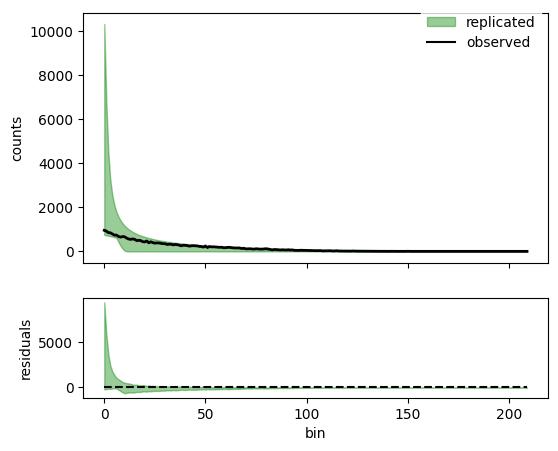


 ---- Prior distributions ---- 



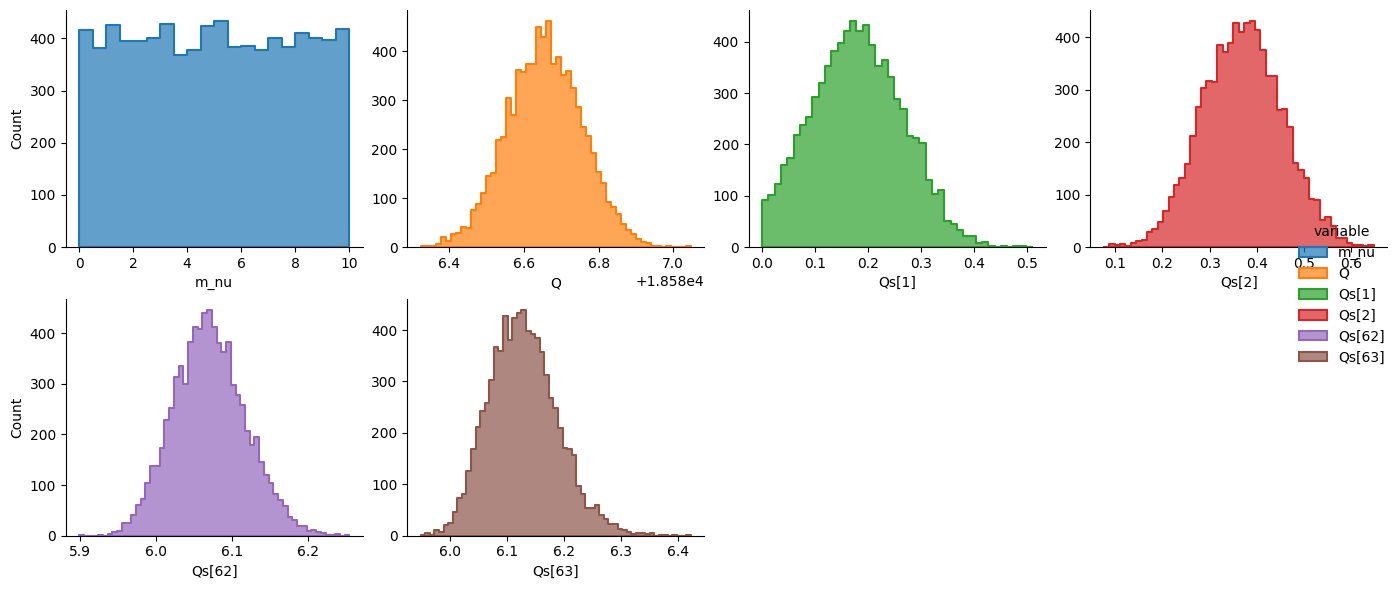


 ---- Fitting the model ---- 



chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

chain 6 |          | 00:00 Status

chain 7 |          | 00:00 Status

chain 8 |          | 00:00 Status

chain 9 |          | 00:00 Status

chain 10 |          | 00:00 Status

chain 11 |          | 00:00 Status

chain 12 |          | 00:00 Status

chain 13 |          | 00:00 Status

chain 14 |          | 00:00 Status

chain 15 |          | 00:00 Status

chain 16 |          | 00:00 Status

/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, 

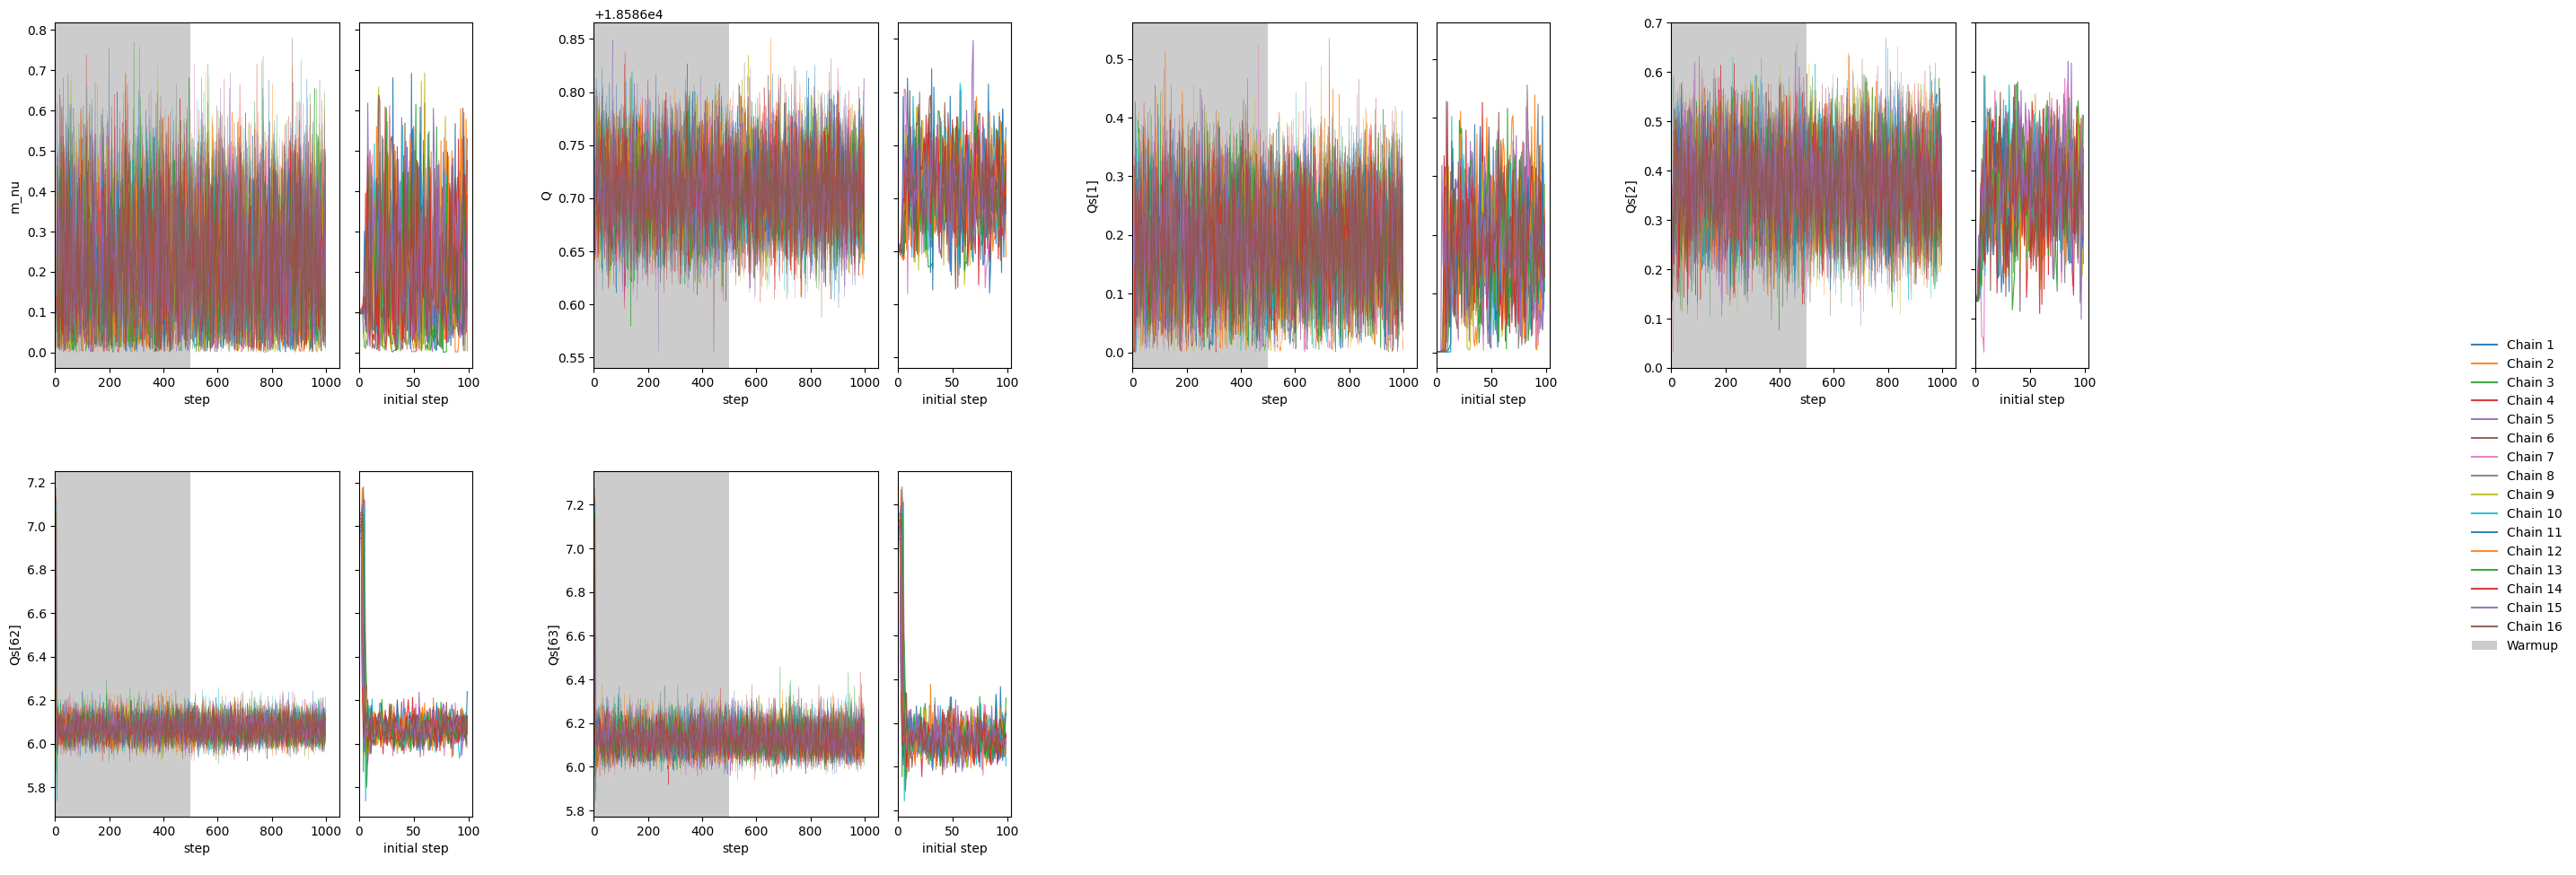


 ---- Posterior predictive check ---- 



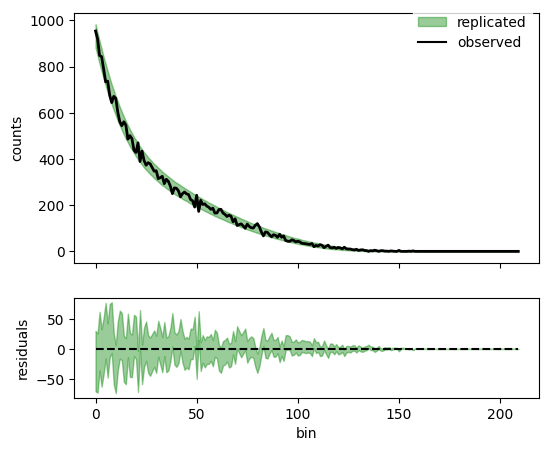


 ---- Posterior distributions ---- 



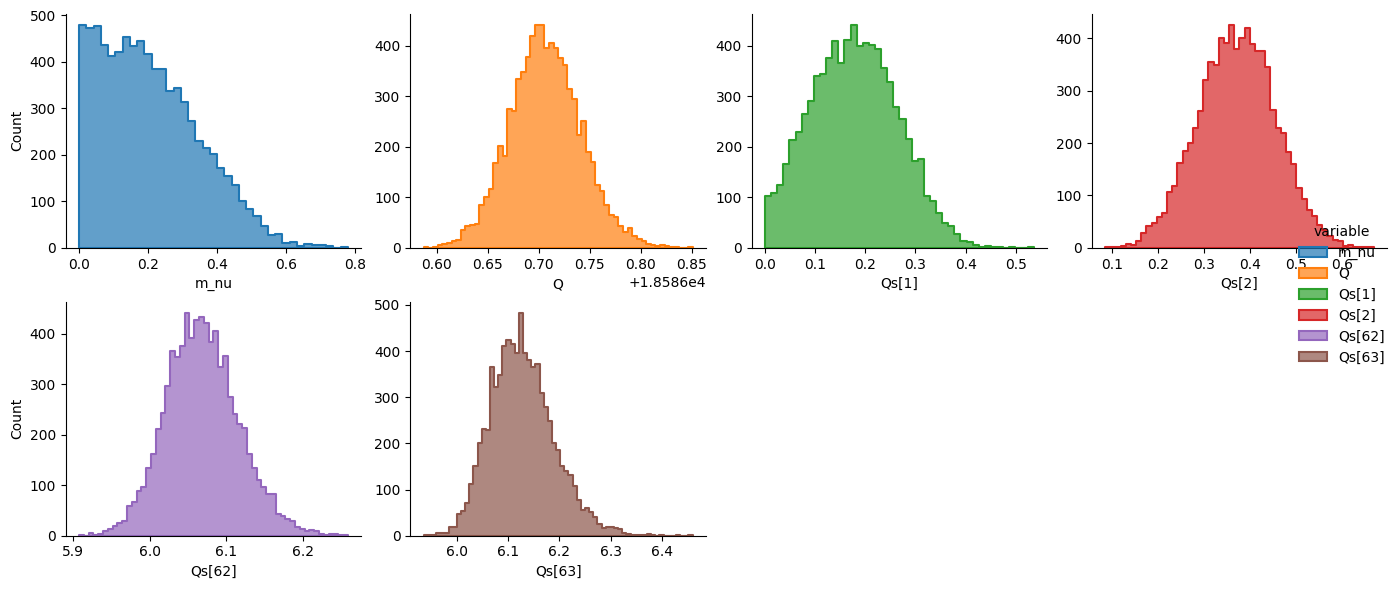


 ---- Prior vs posterior comparison ---- 


 Saving files to  data/allQ/1_01_005
Dictionary saved to data/allQ/1_01_005/data.json


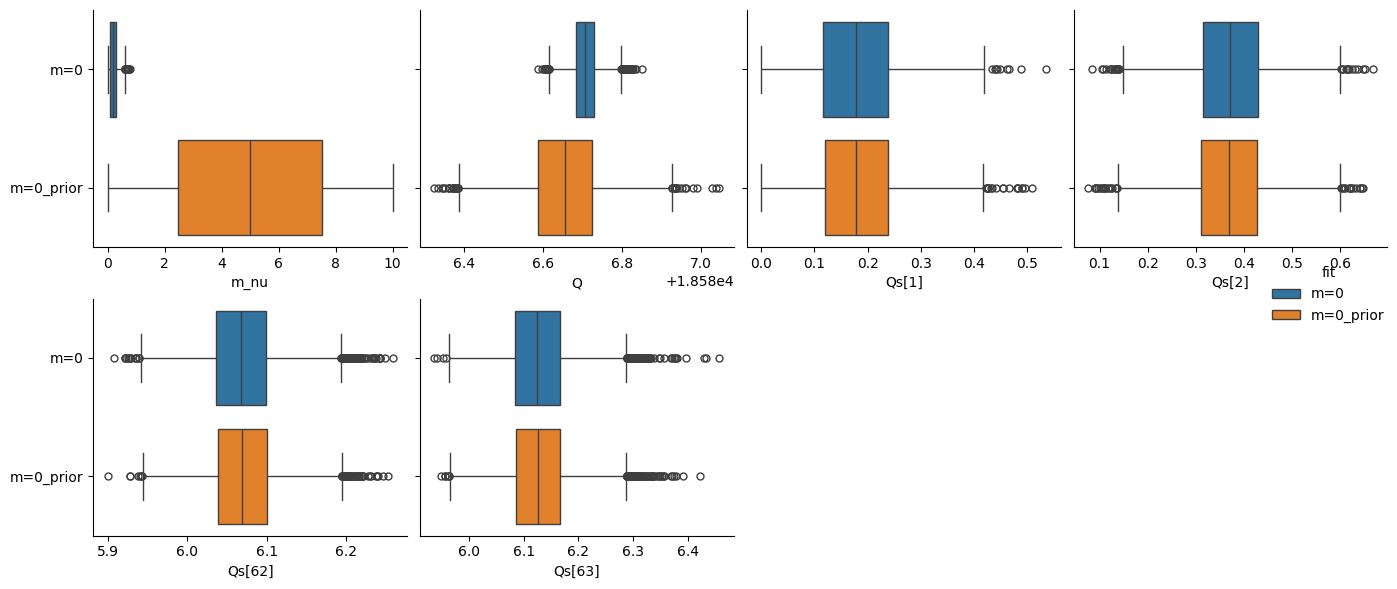

In [7]:
model= get_model("ptolemy_endpoint_allQs.stan")

data["p_std_Qs"]= 0.1

sampler_kwargs={
    'chains': 16,
    'iter_warmup': 500,
    'iter_sampling': 500,
    'save_warmup': True,
    'adapt_delta': 0.9,
    "sig_figs": 10,
    "show_console": False,
    "inits": {"m_red": 0.01, "z": 0, "Qs":np.linspace(0.001, 6, 63)}
}

plot_pars = ['m_nu', 'Q', "Qs[1]", "Qs[2]", "Qs[62]", "Qs[63]"]
p = FitPlotter(col_wrap=4)

#fit = model.sample(data, chains=1, fixed_param=True , iter_sampling=4, iter_warmup=1)

fit = standard_analysis(model, data, p, sampler_kwargs, fit_title='m=0', plot_params = plot_pars, output_dir="data/allQ/1_01_005")

Expected number of events in ROI:  41759
Found .stan file  /home/pietro/work/TESI/BAYNES/baynes/stan/models/ptolemy/ptolemy_endpoint.stan


KeyboardInterrupt: 

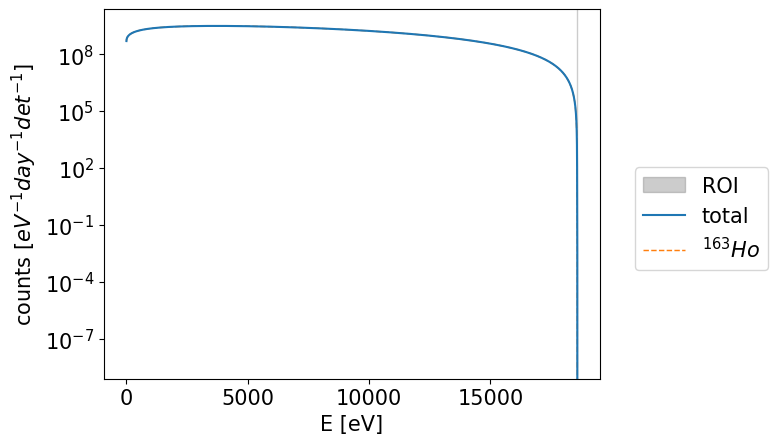

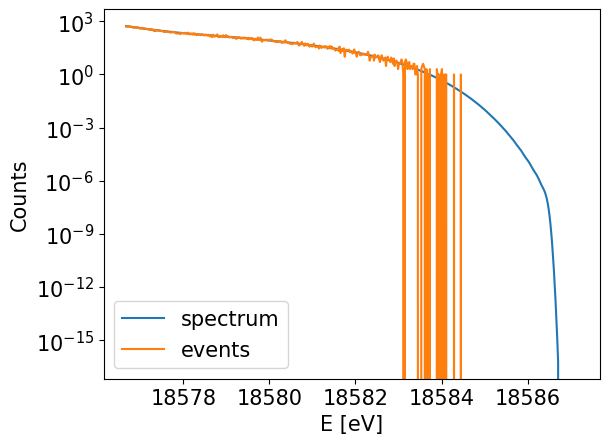

In [6]:
m = 0.2
A = 3.57e8
A_T = A * 1
bkg = 0
FWHM= 0.1
s_Q = 0.1
#n_events  = normM10 * 300


s = SpectraSampler({'$^{163}Ho$': [ptolemy, [coeffs, m, Q], A_T]}, flat_bkg=bkg, FWHM=FWHM, dE=0.02, integrate=False, ROI=[Q-10, Q+0.5])
s.plot_spectrum()
s.set_measure_time(365, n_det=1)

events = s.sample()[0]
s.plot_events(events)

data={'N_bins': len(events),
      'x': s.ROI_bin_edges,
      "N_ev": s.n_events,
      'counts': events,
      'p_Q': Q,
      'p_std_Q': s_Q,
      'p_FWHM': FWHM,
      'p_std_FWHM': 0.01,
      'm_max':10,
      "coeffs": coeffs,
      "prior":1
}

model_noQ = get_model("ptolemy_endpoint.stan")
sampler_kwargs={
    'chains': 16,
    'iter_warmup': 500,
    'iter_sampling': 500,
    'save_warmup': True,
    'adapt_delta': 0.9,
    "sig_figs": 10,
    "show_console": False,
    "inits": {"m_red": 0.01, "z": 0}
}
plot_pars = ['m_nu', 'Q']
#p = FitPlotter(col_wrap=4)
#fit_noQs = standard_analysis(model_noQ, data, p, sampler_kwargs, fit_title='m=0', plot_params = plot_pars, output_dir="data/allQ/noQs_300_02")

Found .stan file  /home/pietro/work/TESI/baynes/stan/models/ptolemy/ptolemy_endpoint_allQs.stan

 ---- Sampling the priors ---- 


 ---- Prior predictive check ---- 



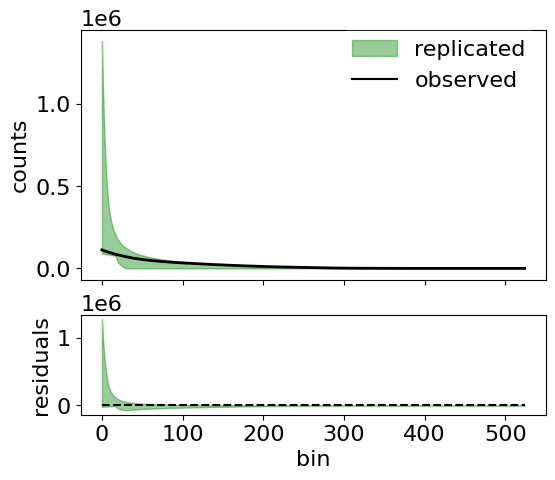


 ---- Prior distributions ---- 



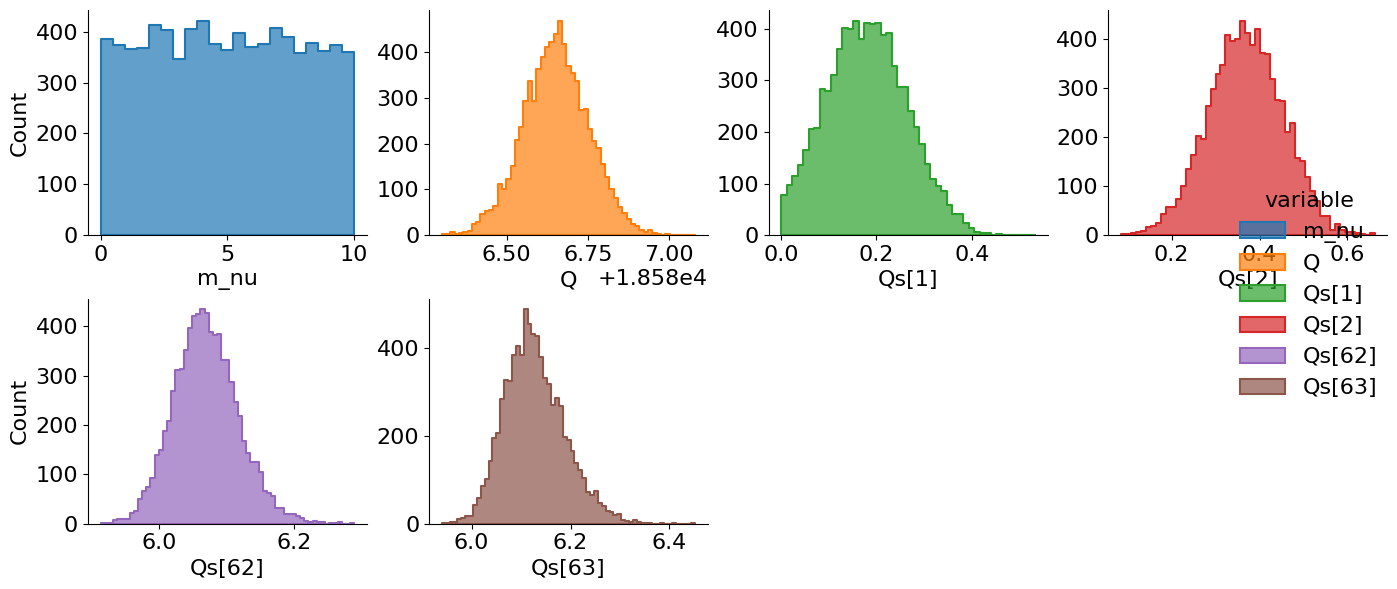


 ---- Fitting the model ---- 



chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

chain 6 |          | 00:00 Status

chain 7 |          | 00:00 Status

chain 8 |          | 00:00 Status

chain 9 |          | 00:00 Status

chain 10 |          | 00:00 Status

chain 11 |          | 00:00 Status

chain 12 |          | 00:00 Status

chain 13 |          | 00:00 Status

chain 14 |          | 00:00 Status

chain 15 |          | 00:00 Status

chain 16 |          | 00:00 Status

/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, 

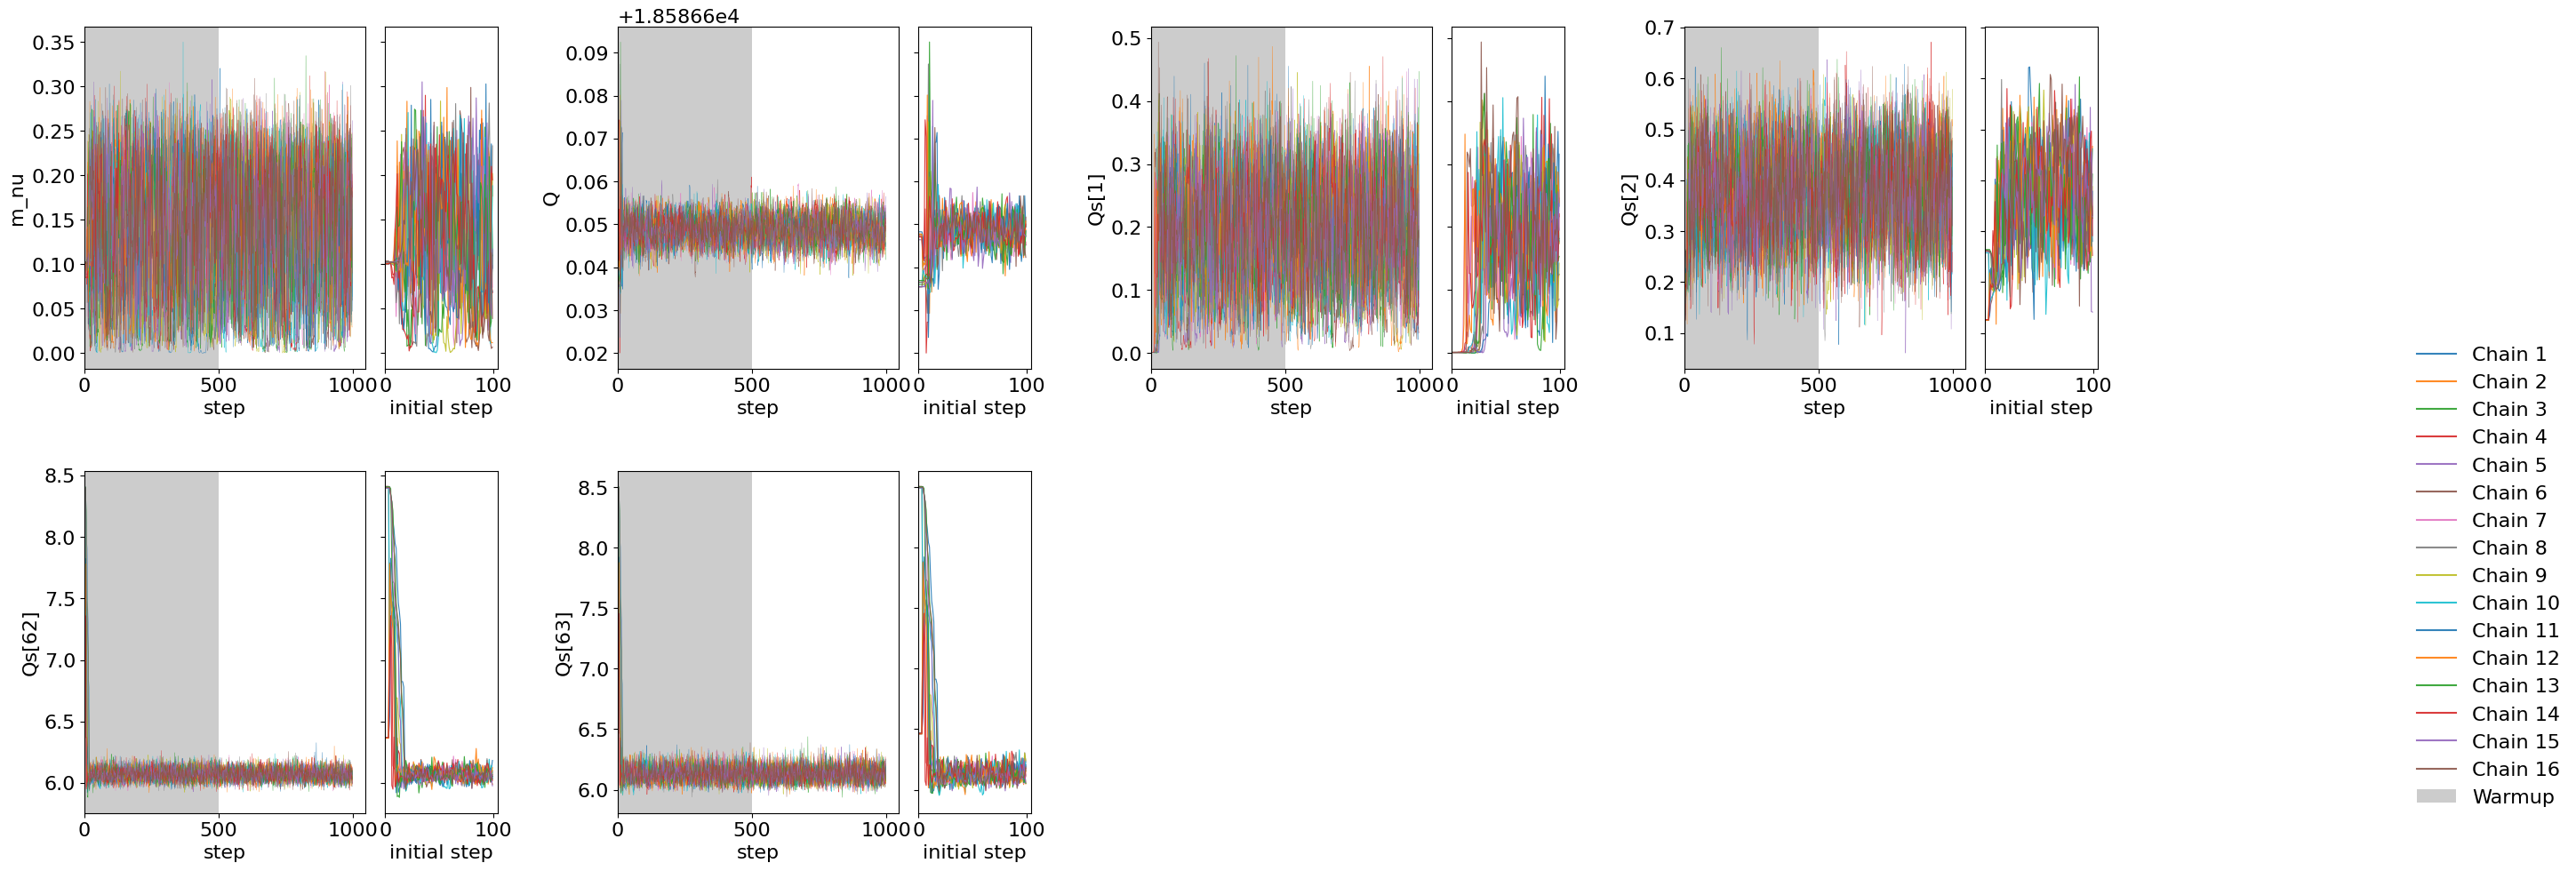


 ---- Posterior predictive check ---- 



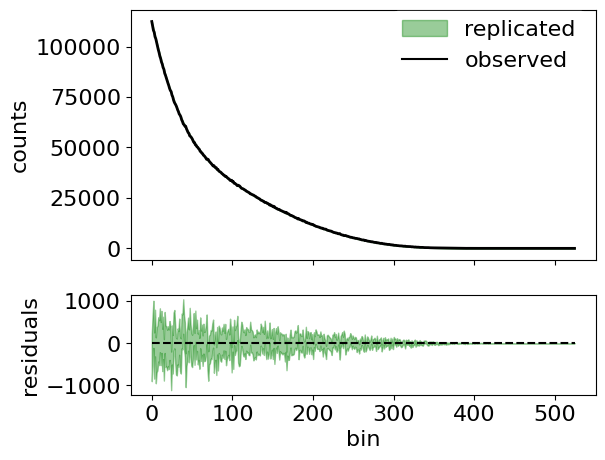


 ---- Posterior distributions ---- 



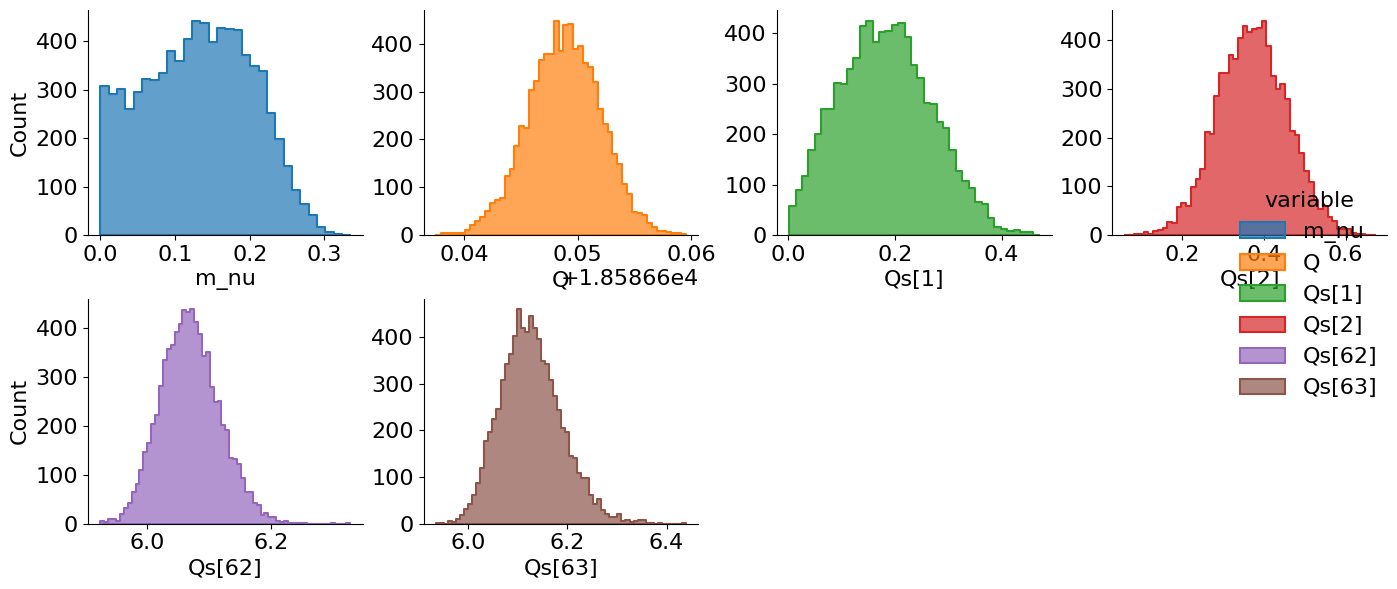


 ---- Prior vs posterior comparison ---- 


 Saving files to  data/allQ/300_01_m02
Dictionary saved to data/allQ/300_01_m02/data.json

 ---- Sampling the priors ---- 


 ---- Prior predictive check ---- 



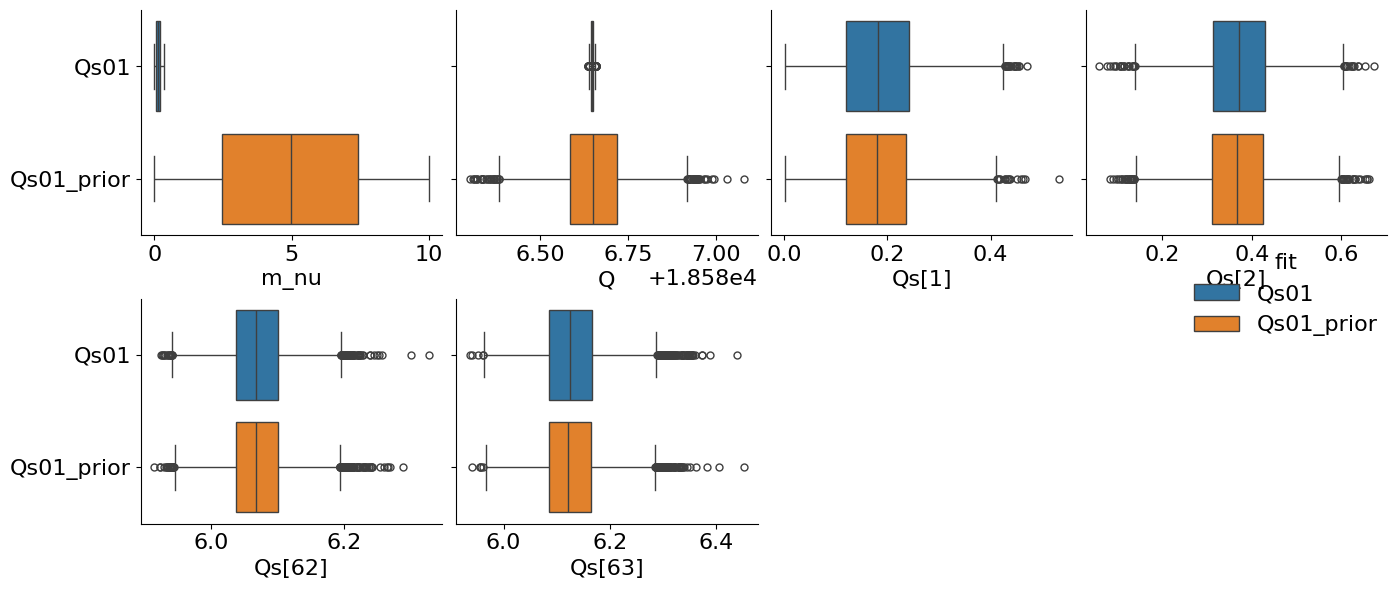

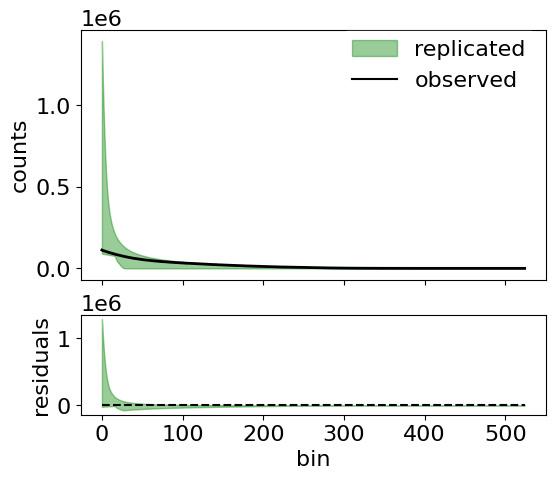


 ---- Prior distributions ---- 



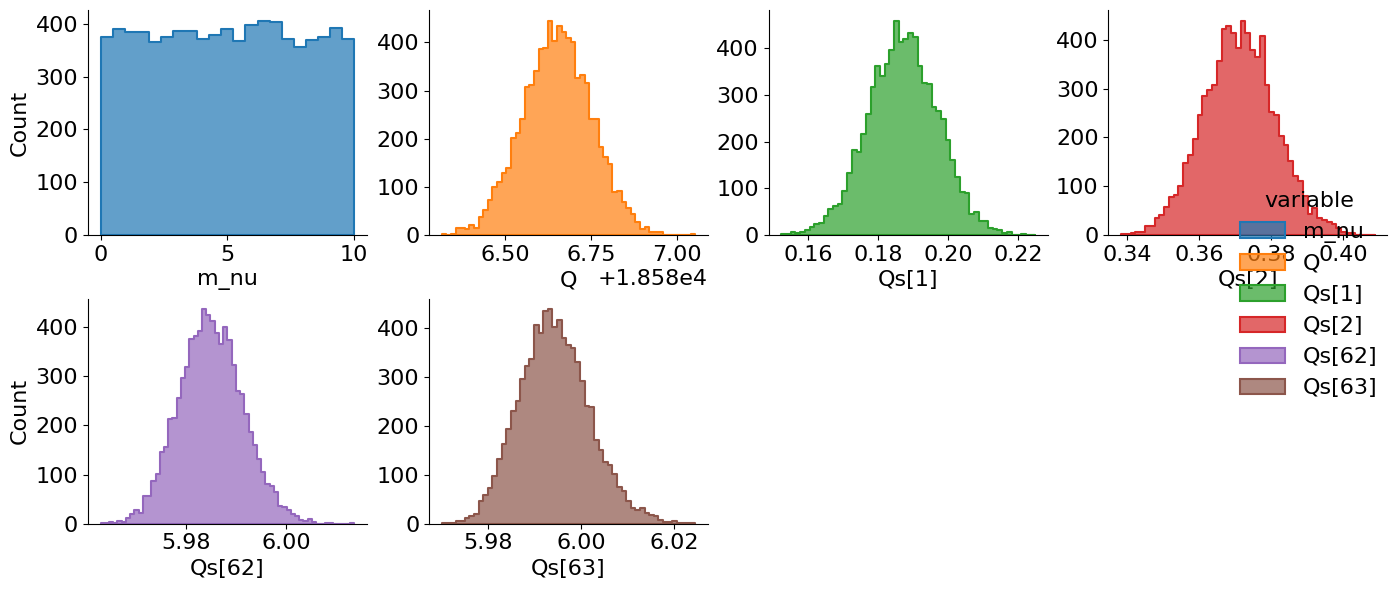


 ---- Fitting the model ---- 



chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

chain 6 |          | 00:00 Status

chain 7 |          | 00:00 Status

chain 8 |          | 00:00 Status

chain 9 |          | 00:00 Status

chain 10 |          | 00:00 Status

chain 11 |          | 00:00 Status

chain 12 |          | 00:00 Status

chain 13 |          | 00:00 Status

chain 14 |          | 00:00 Status

chain 15 |          | 00:00 Status

chain 16 |          | 00:00 Status

/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, 

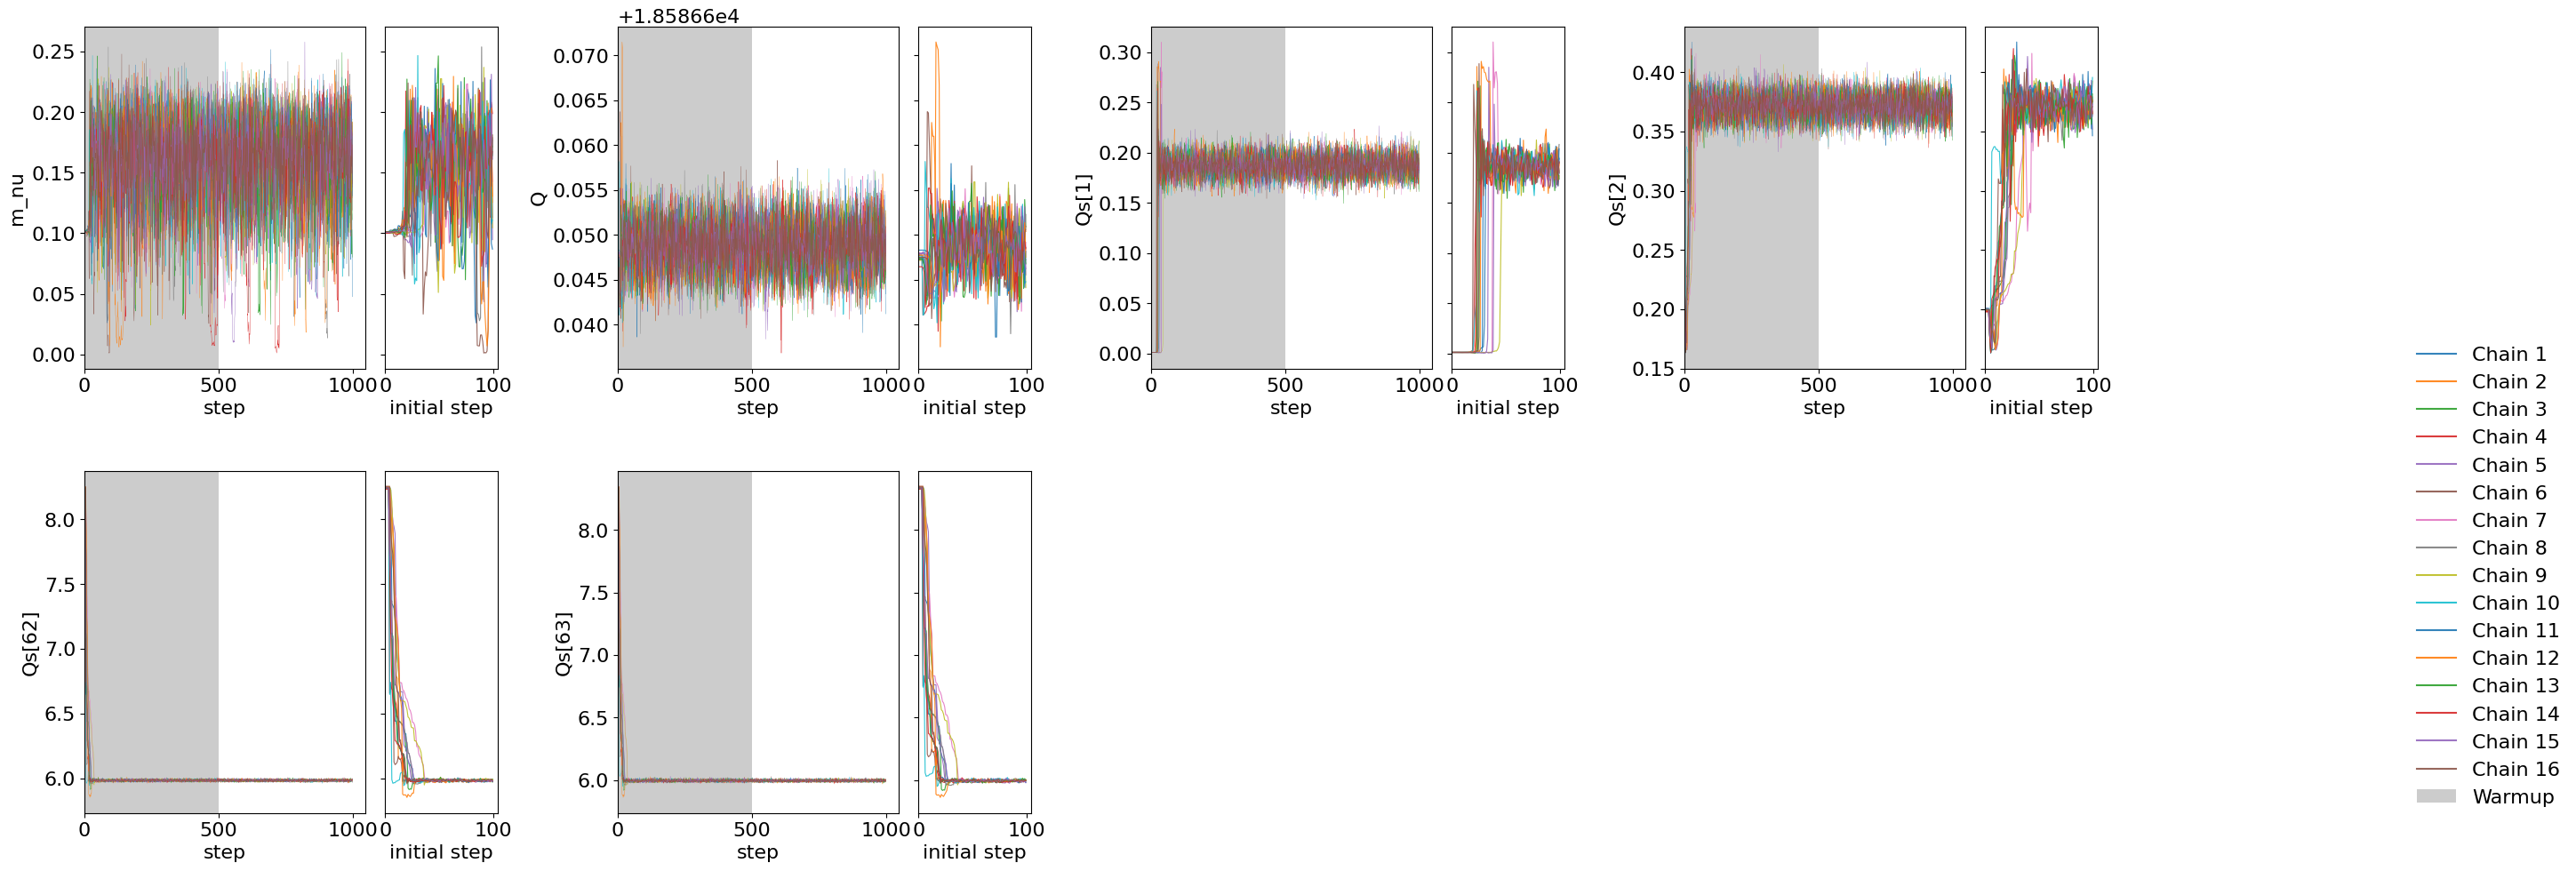


 ---- Posterior predictive check ---- 



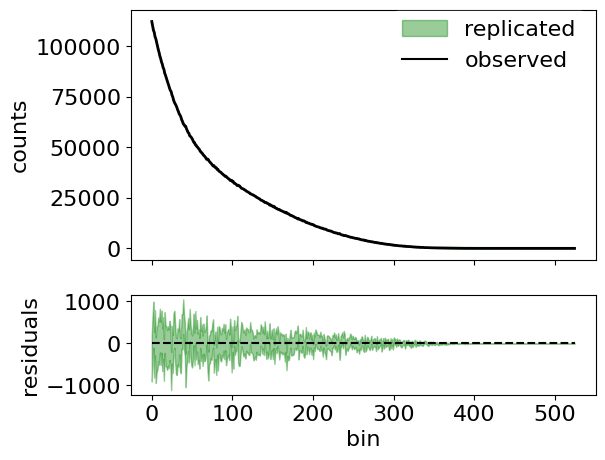


 ---- Posterior distributions ---- 



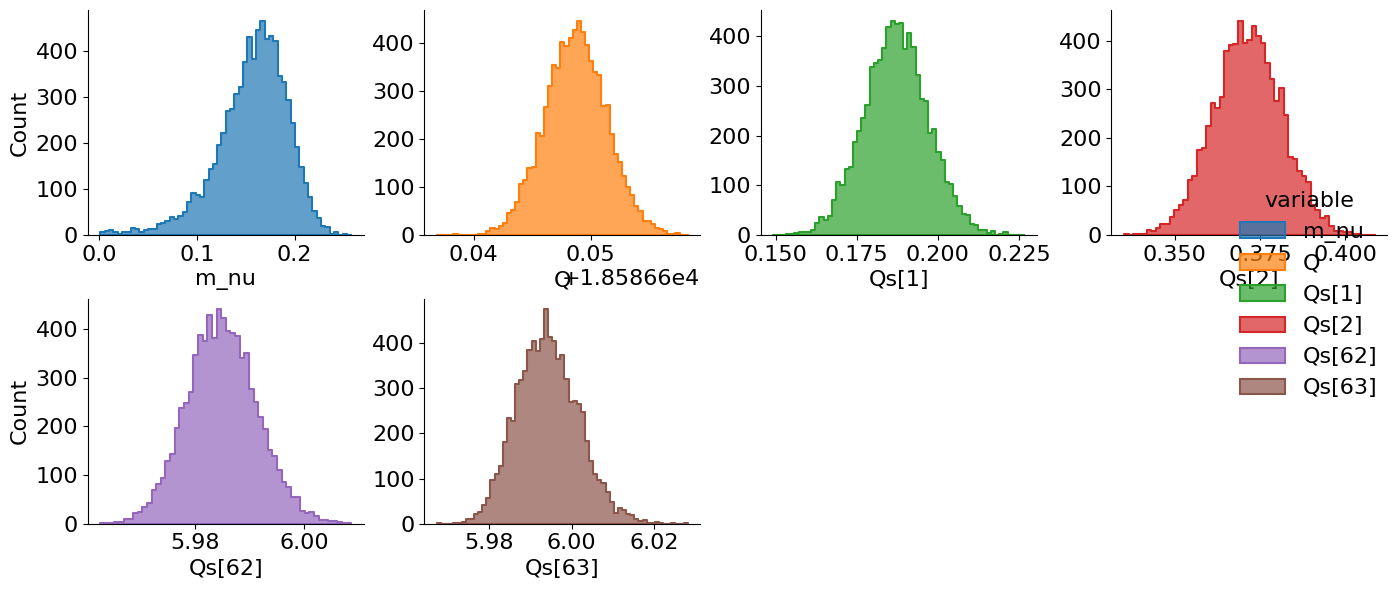


 ---- Prior vs posterior comparison ---- 


 Saving files to  data/allQ/300_001_m02
Dictionary saved to data/allQ/300_001_m02/data.json


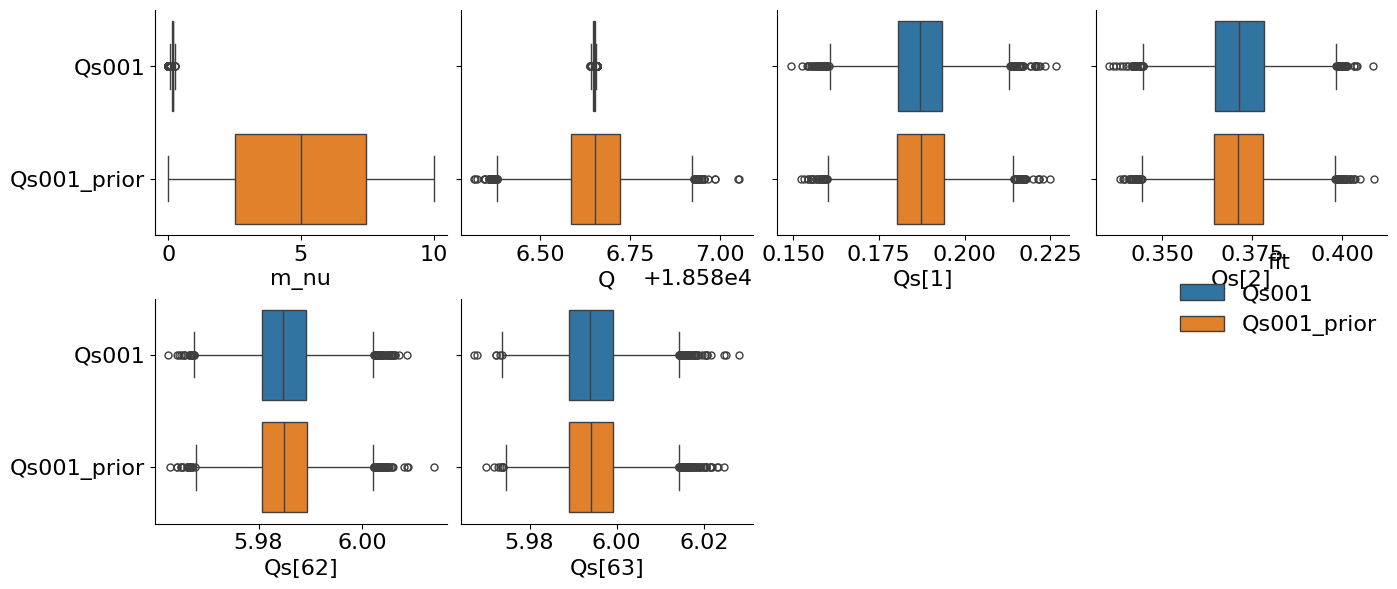

In [12]:
model= get_model("ptolemy_endpoint_allQs.stan")

sampler_kwargs={
    'chains': 16,
    'iter_warmup': 500,
    'iter_sampling': 500,
    'save_warmup': True,
    'adapt_delta': 0.9,
    "sig_figs": 10,
    "show_console": False,
    "inits": {"m_red": 0.01, "z": 0, "Qs":np.linspace(0.001, 6, 63)}
}

plot_pars = ['m_nu', 'Q', "Qs[1]", "Qs[2]", "Qs[62]", "Qs[63]"]
data["p_std_Qs"]= 0.1
Qsbig = standard_analysis(model, data, p, sampler_kwargs, fit_title='Qs01', plot_params = plot_pars, output_dir="data/allQ/300_01_m02")
data["p_std_Qs"]= 0.01
Qssmal = standard_analysis(model, data, p, sampler_kwargs, fit_title='Qs001', plot_params = plot_pars, output_dir="data/allQ/300_001_m02")

In [ ]:
data["p_std_Qs"]= 0.01
fitsmaller = standard_analysis(model, data, p, sampler_kwargs, fit_title='m=0', plot_params = plot_pars, output_dir="data/allQ/100_001_m02")

In [ ]:
p.pair_grid(parameters=['m_nu', 'Q'])

In [13]:
model= get_model("ptolemy_endpoint.stan")

def nu_mass_fit(m):
    n_events = normM10 * 3 * 100
    s = SpectraSampler({'$^{163}Ho$': [ptolemyint, [coeffs, m, Q], A_T]}, flat_bkg=bkg, FWHM=FWHM, dE=0.02, integrate=True, ROI=[Q-10, Q+0.5], n_events=n_events)
    events = s.sample()[0]
    print(f"n events = {n_events}")

    data={'N_bins': len(events),
          'x': s.ROI_bin_edges,
          "N_ev": s.n_events,
          'counts': events,
          'p_Q': Q,
          'p_std_Q': s_Q,
          'p_FWHM': FWHM,
          'p_std_FWHM': 0.01,
          'm_max':10,
          "coeffs": coeffs,
          "prior":0
    }


    inits={}
    inits['m_nu_red'] = np.random.uniform(0,0.01)
    inits['z'] = np.random.normal(0, 0.1)

    sampler_kwargs={
        'chains': 1,
        'iter_warmup': 500,
        'iter_sampling': 1000,
        'save_warmup': False,
        'adapt_delta': 0.9,
        "sig_figs": 10,
        "show_console": False,
        "show_progress": False,
        "inits": inits
    }

    fit = model.sample(data, **sampler_kwargs)
    print("fit ok")
    return fit

n_fits = 64
n_processes = 32
#result = multithreaded_run(nu_mass_fit, [m]*n_fits, n_processes)

Found .stan file  /home/pietro/work/TESI/baynes/stan/models/ptolemy/ptolemy_endpoint.stan


In [86]:
import json



In [87]:
posteriors = []
for fit in result:
    posteriors.append(fit.draws_pd()['m_nu'].to_numpy().flatten())

In [88]:
data[0.2] = posteriors
dict_to_json(m_data_array, "data/msweep1.json")


Dictionary saved to data/msweep1.json


In [ ]:
data = {}
m=0.05
efficiency = [0.1, 1, 10, 100, 1000]
for e in efficiency:
    s.n_events = normM10 * e
    data[e] = multithreaded_run(nu_mass_fit, [m]*n_fits, n_processes)

data_array = {}
for key, item in data.items():
    posteriors = []
    for fit in item:
        posteriors.append(fit.draws_pd()['m_nu'].to_numpy().flatten())
    posteriors = np.array(posteriors)
    data_array[key] = posteriors
dict_to_json(data_array, "ptolemy/m005.json")

In [14]:
data = {}
m_nus = [0.0001, 0.05, 0.1, 0.2, 0.3, 0.5]
for m in m_nus:
    data[m] = multithreaded_run(nu_mass_fit, [m]*n_fits, n_processes)

m_data_array = {}
for key, item in data.items():
    posteriors = []
    for fit in item:
        posteriors.append(fit.draws_pd()['m_nu'].to_numpy().flatten())
    posteriors = np.array(posteriors)
    m_data_array[key] = posteriors

dict_to_json(m_data_array, "data/msweep100_v2.json")


n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
n events = 8822100
fit ok
fit ok
n events = 8822100
n events = 8822100
fit ok
fit ok
fit ok
n events = 8822100
n events = 8822100
n events = 8822100
fit ok
fit ok
fit ok
fit ok
fit ok
fit ok
fit ok
fit ok
fit ok
fit ok
fit ok
fit ok
fit ok
n events = 8822100
fit ok
fit ok
fit ok
fit ok
fit ok
fit ok
fit ok
fit ok
fit ok
fit ok
n events = 8822100
fit ok
fit ok
n events = 8822100
fit ok
n events = 8822100
n ev

In [ ]:
from baynes import dict_to_json

data_array = {}
for key, item in data.items():
    posteriors = []
    for fit in item:
        posteriors.append(fit.draws_pd()['m_nu'].to_numpy().flatten())
    posteriors = np.array(posteriors)
    data_array[key] = posteriors
dict_to_json(data_array, "ptolemy/m0.json")

### Plot the posteriors for $m_\nu$ and combine their samples in a histogram. The upper limit on the parameter's estimate is given by the confidence interval of this distribution.

68.0% highest density interval:  [7.44368820e-05 2.20264697e-01]
90.0% highest density interval:  [1.54380831e-05 3.47997184e-01]


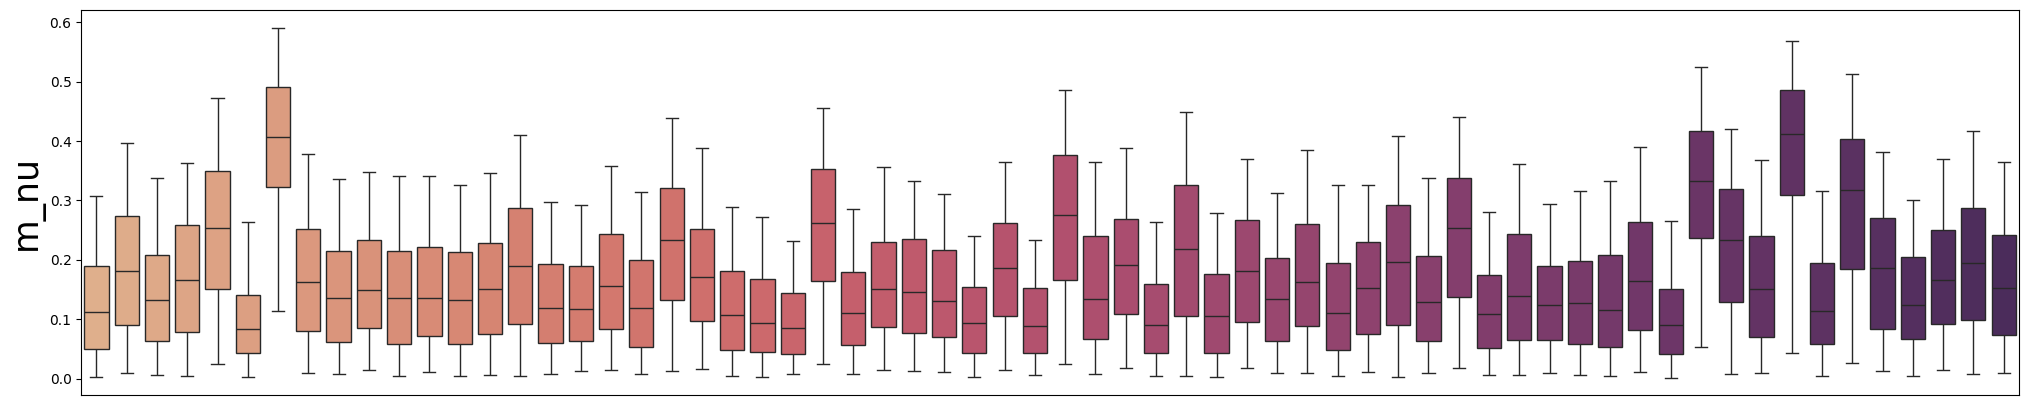

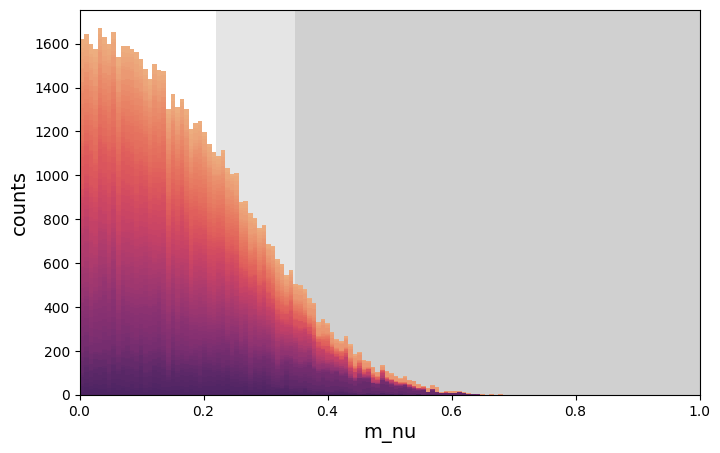

In [56]:
posteriors = []
#for fit in data[0.5]:
  #  posteriors.append(fit.draws_pd()['m_nu'].to_numpy().flatten())
posteriors = np.array(data["0.0001"])

p = FitPlotter(col_wrap=4)

ax = p.new_figure('multi').subplots()
sns.boxplot(posteriors.transpose(), whis=[2.5, 95], showfliers=False, palette='flare', ax=ax)
ax.figure.set_size_inches(25, 5)
ax.set_xticks([])
ax.set_ylabel('m_nu', fontsize=25)


full = posteriors.flatten()
ax = p.new_figure('multi').subplots()
x_max=1

prob = 0.68
print( str(prob*100) + '% highest density interval: ', hdi(full, prob=prob))
ax.axvspan(hdi(full, prob=prob)[1], x_max, color='gray', alpha=0.2, lw=0)

prob = 0.9
print( str(prob*100) + '% highest density interval: ', hdi(full, prob=prob))
ax.axvspan(hdi(full, prob=prob)[1], x_max, color='gray', alpha=0.2, lw=0)

sns.histplot(posteriors.transpose(), bins=100, alpha=1, multiple='stack', legend=False, lw=0., palette='flare', ax=ax)
ax.grid(False)
ax.set_xlim(0, x_max)
ax.set_xlabel('m_nu', fontsize=14)
ax.set_ylabel('counts', fontsize=14)
ax.figure.set_size_inches(8, 5)

In [57]:
with open("data/msweep1_v3.json") as f:
    data = json.load(f)

los_1, his_1 = [], []
for key, posteriors in data.items():
    post = []
    for p in posteriors:
        if np.mean(p)<2:
            post.extend(p)
    lo, hi = hdi(post, prob=0.9)
    print(lo, hi)
    los_1.append(lo)
    his_1.append(hi)

1.543808314e-05 0.3479971842
6.383443273e-07 0.3809764267
6.584785842e-05 0.3810820666
3.829658328e-06 0.3963537353
0.002238942116 0.4878039984
0.199309043 0.7291321722


In [41]:
data.keys()

dict_keys(['0.0001', '0.05', '0.1', '0.2', '0.3', '0.5'])

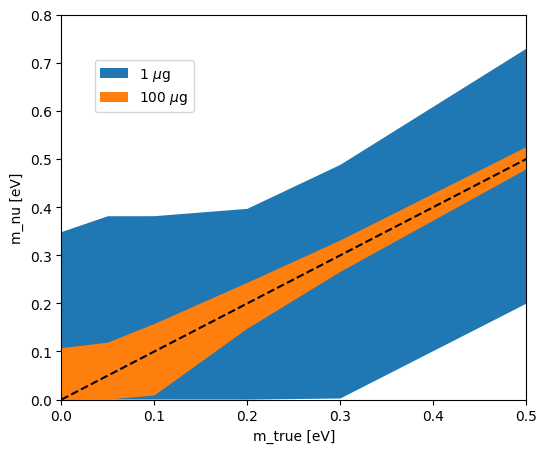

In [58]:
los, his = [], []
for key, posteriors in m_data_array.items():
    post = []
    for p in posteriors:
        if np.mean(p)<2:
            post.extend(p)
    lo, hi = hdi(post, prob=0.9)
    los.append(lo)
    his.append(hi)

fp = FitPlotter(col_wrap=4)


ms = list(m_data_array.keys())
ax = fp.new_figure("msweep").subplots()
ax.fill_between(ms, los_1, his_1, label="1 $\mu$g")
ax.fill_between(ms, los, his, label="100 $\mu$g")
plt.plot([0, 0.5], [0, 0.5], color="black", ls="--")
ax.set_xlim(0,0.5)
ax.set_ylim(0, 0.8)
ax.set_xlabel("m_true [eV]")
ax.set_ylabel("m_nu [eV]")
ax.legend(bbox_to_anchor=(0.3,0.9))
#plt.xscale("log")

In [59]:
with open("ptolemy/m0.json") as f:
    datan = json.load(f)

los_n, his_n = [], []
for key, posteriors in datan.items():
    post = []
    for p in posteriors:
        if np.mean(p)<2:
            post.extend(p)
    lo, hi = hdi(post, prob=0.9)
    print(lo, hi)
    los_n.append(lo)
    his_n.append(hi)

1.951233167e-05 0.5835597544
3.216534935e-05 0.3855025469
8.751695375e-06 0.2317320208
3.309370353e-06 0.1273129543


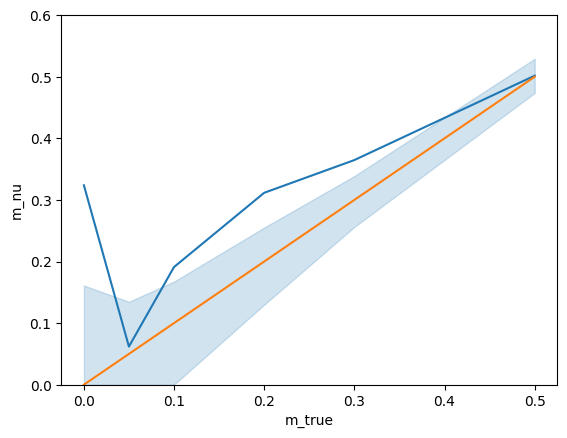

In [18]:
m_flatten = {"m_true": [], "m_nu": []}
for key, item in m_data_array.items():
    y = item.flatten()
    for i, yval in enumerate(y):
        m_flatten["m_nu"].append(yval)
        m_flatten["m_true"].append(key)
#m_flattened = {"m_true": list(m_data_array.keys()), "m_nu": np.array([item.flatten() for _, item in m_data_array.items()]).transpose()}
sns.lineplot(m_flatten, x="m_true", y="m_nu", errorbar=hdi)
plt.ylim(0, .6)
plt.plot([0, 0.5], [0, 0.5])


In [60]:
pd.DataFrame.from_dict(m_flatten).melt()

variable                                              value
0   m_true  [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.000...
1   m_true  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...
2   m_true  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...
3   m_true  [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, ...
4   m_true  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...
5     m_nu  [0.2408222735, 0.2563012437, 0.3664973446, 0.3...
6     m_nu  [0.2409980114, 0.3064648685, 0.2803514562, 0.2...
7     m_nu  [0.01602791693, 0.01822748129, 0.01723657082, ...
8     m_nu  [0.3181408844, 0.2337398853, 0.360632312, 0.36...
9     m_nu  [0.4569358786, 0.5551789008, 0.4679382275, 0.3...

In [107]:
def load_file(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return data

def get_los_his(data, prob):
    los, his = [], []
    for key, posteriors in data.items():
        post = []
        for p in posteriors:
            if np.mean(p)<2:
                post.extend(p)
        lo, hi = hdi(post, prob=prob)
        los.append(lo)
        his.append(hi)
    return los, his

In [60]:
effs = np.log10(np.array(his_n))
pars = np.polyfit(np.log10(np.array(his_n)), his_n, 1)

In [145]:
from scipy.optimize import curve_fit
def power_fit(x, alpha, beta):
    return beta*np.power(x, alpha)

ns = np.array([float(k) for k in datan.keys()])*36000
pars, errs = curve_fit(power_fit, ns, his_n)

In [100]:
print(pars)

[-0.20481458  3.16092996]


[-0.21096293  1.53040588]
[-0.20738669  2.10585823]
[-0.20481458  3.16092996]


Text(46000.0, 0.5, 'hi$(m_\\nu)\\propto N^{-0.21}$')

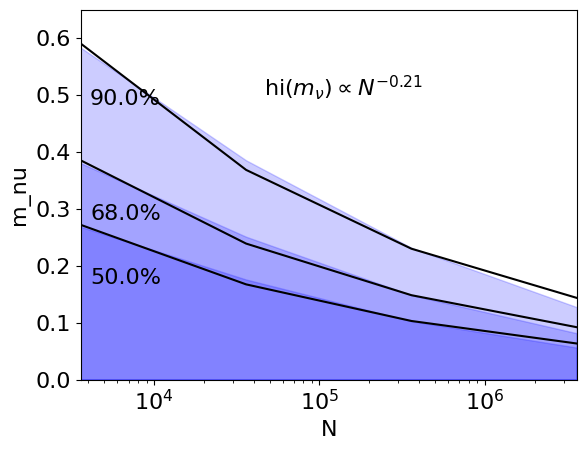

In [164]:
for prob in [0.5, 0.68, 0.9]:
    los, his = get_los_his(datan, prob)

    pars, errs = curve_fit(power_fit, ns, his)
    print(pars)
    plt.fill_between(ns, 0, his, alpha=0.2, color="b")
    plt.text(ns[0]+500, his[0]-0.1, f"{prob*100}%")
    plt.plot(ns, power_fit(ns, pars[0], pars[1]), color="black")
    #plt.plot(ns, his)
plt.xlim(ns[0], ns[-1])
plt.ylim(0, 0.65)
plt.xscale("log")
plt.xlabel("N")
plt.ylabel("m_nu")
plt.text(ns[1]+10000, 0.5, r"hi$(m_\nu)\propto N^{-0.21}$")

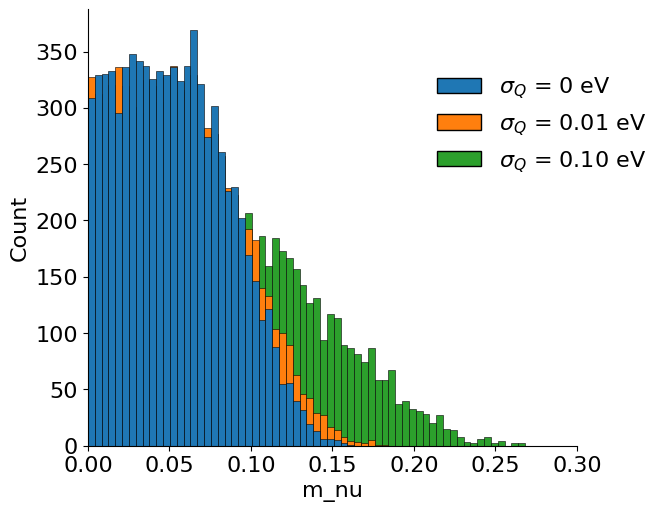

In [23]:
fp = FitPlotter(col_wrap=4)

fit_noQ = cmdstanpy.from_csv("data/allQ/noQs_300_005/posterior")
fit_001 = cmdstanpy.from_csv("data/allQ/300_001_m005/posterior")
fit_01 = cmdstanpy.from_csv("data/allQ/300_01_m005/posterior")
fp.add_fit(fit_01, fit_title="$\sigma_Q$ = 0.10 eV")
fp.add_fit(fit_001, fit_title="$\sigma_Q$ = 0.01 eV")
fp.add_fit(fit_noQ, fit_title="$\sigma_Q$ = 0.00 eV")

fp.dis_plot(fit_titles="all", parameters="m_nu", legend=True, kind="hist", alpha=1)
fp.get_current_figure().axes[0].set_xlim(0,0.3)
fp.update_legend(bbox_to_anchor=(1.1,0.9))

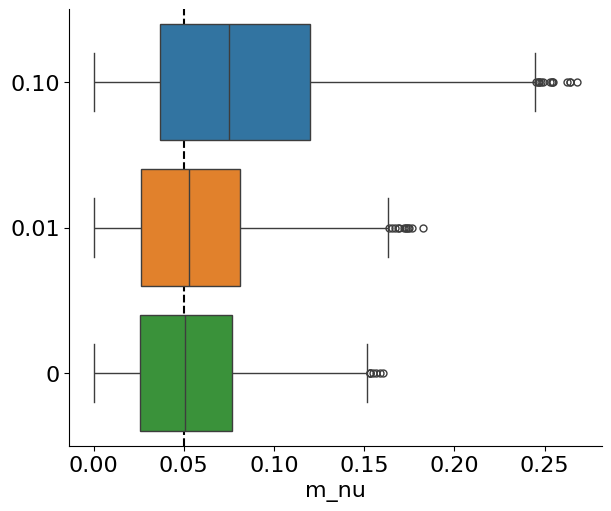

In [199]:
fp.cat_plot(fit_titles="all", parameters="m_nu", legend=False)
fp.add_lines([0.05], zorder=0, ls="--", color="black")


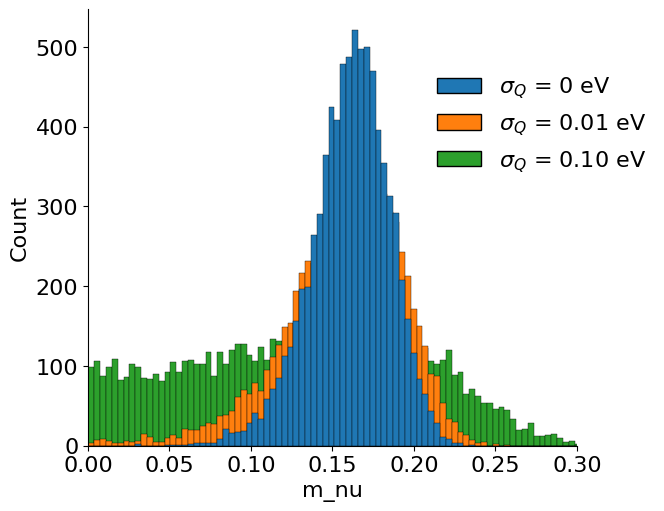

In [22]:
fit_noQ = cmdstanpy.from_csv("data/allQ/noQs_300_02/posterior")
fit_001 = cmdstanpy.from_csv("data/allQ/300_001_m02/posterior")
fit_01 = cmdstanpy.from_csv("data/allQ/300_01_m02/posterior")
fp.add_fit(fit_01, fit_title="$\sigma_Q$ = 0.10 eV")
fp.add_fit(fit_001, fit_title="$\sigma_Q$ = 0.01 eV")
fp.add_fit(fit_noQ, fit_title="$\sigma_Q$ = 0.00 eV")

fp.dis_plot(fit_titles="all", parameters="m_nu", legend=True, kind="hist", alpha=1)
fp.get_current_figure().axes[0].set_xlim(0,0.3)
fp.update_legend(bbox_to_anchor=(1.1,0.9))

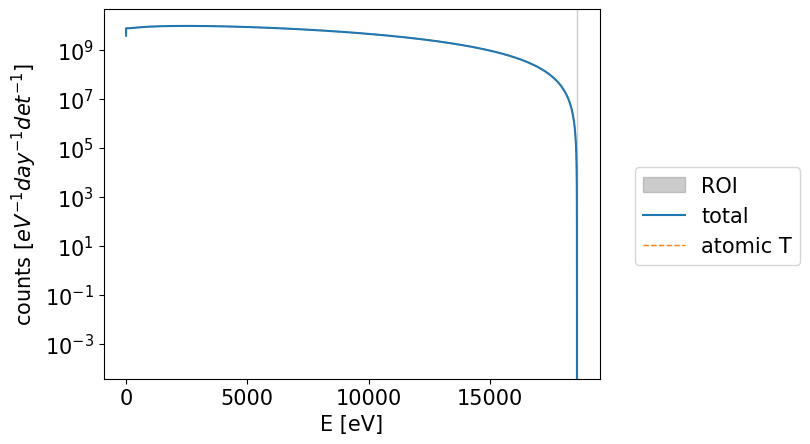

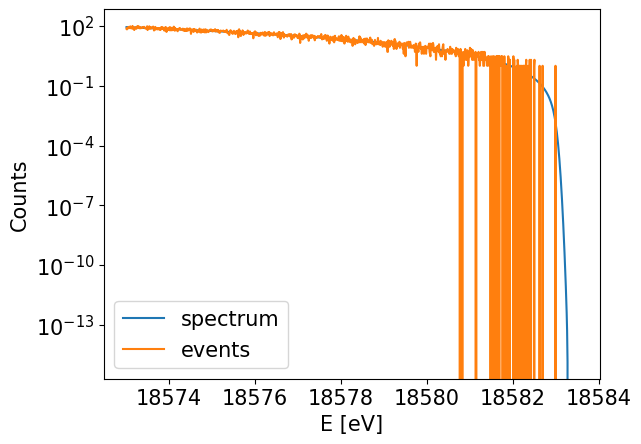

In [16]:
m = 0.00001
A = 3.57e8
A_T = A * 3
n_days=365
bkg = 0
FWHM= 0.1
s_Q = 0.1
n_events  = normM10_corr


s = SpectraSampler({'atomic T': [allowed_beta, [m, QT], A_T]}, flat_bkg=bkg, FWHM=FWHM, dE=0.01, integrate=False, ROI=[QT-10, QT+0.5], n_events=n_events)
s.plot_spectrum()

events = s.sample()[0]
s.plot_events(events)

data={'N_bins': len(events),
      'x': s.ROI_bin_edges,
      "N_ev": s.n_events,
      'counts': events,
      'p_Q': QT,
      'p_std_Q': s_Q,
      'p_FWHM': FWHM,
      'p_std_FWHM': 0.01,
      'm_max':10,
      "coeffs": coeffs,
      "prior":1
}

Found .stan file  /home/pietro/work/TESI/baynes/stan/models/allowed_beta/beta_endpoint.stan

 ---- Sampling the priors ---- 


 ---- Prior predictive check ---- 



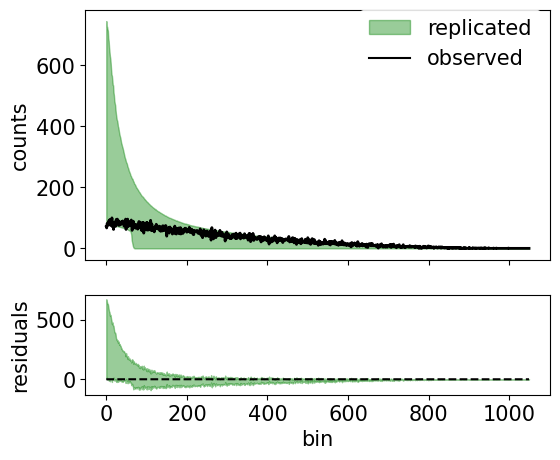


 ---- Prior distributions ---- 



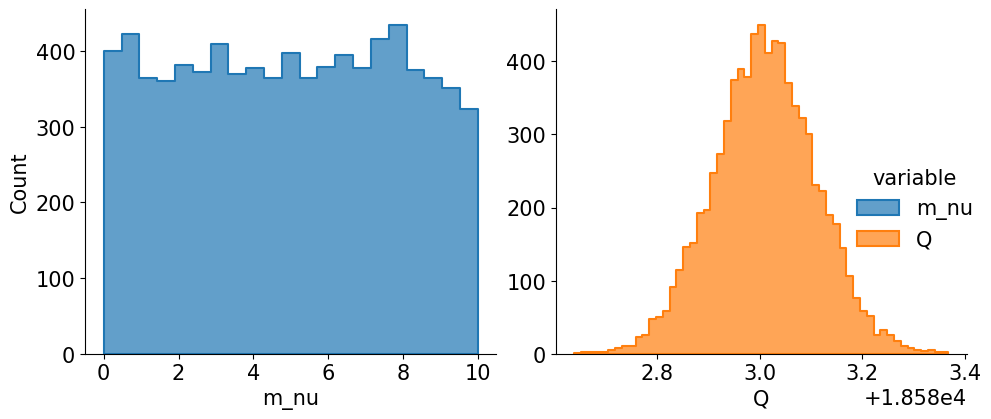


 ---- Fitting the model ---- 



chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

chain 6 |          | 00:00 Status

chain 7 |          | 00:00 Status

chain 8 |          | 00:00 Status

chain 9 |          | 00:00 Status

chain 10 |          | 00:00 Status

chain 11 |          | 00:00 Status

chain 12 |          | 00:00 Status

chain 13 |          | 00:00 Status

chain 14 |          | 00:00 Status

chain 15 |          | 00:00 Status

chain 16 |          | 00:00 Status

/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


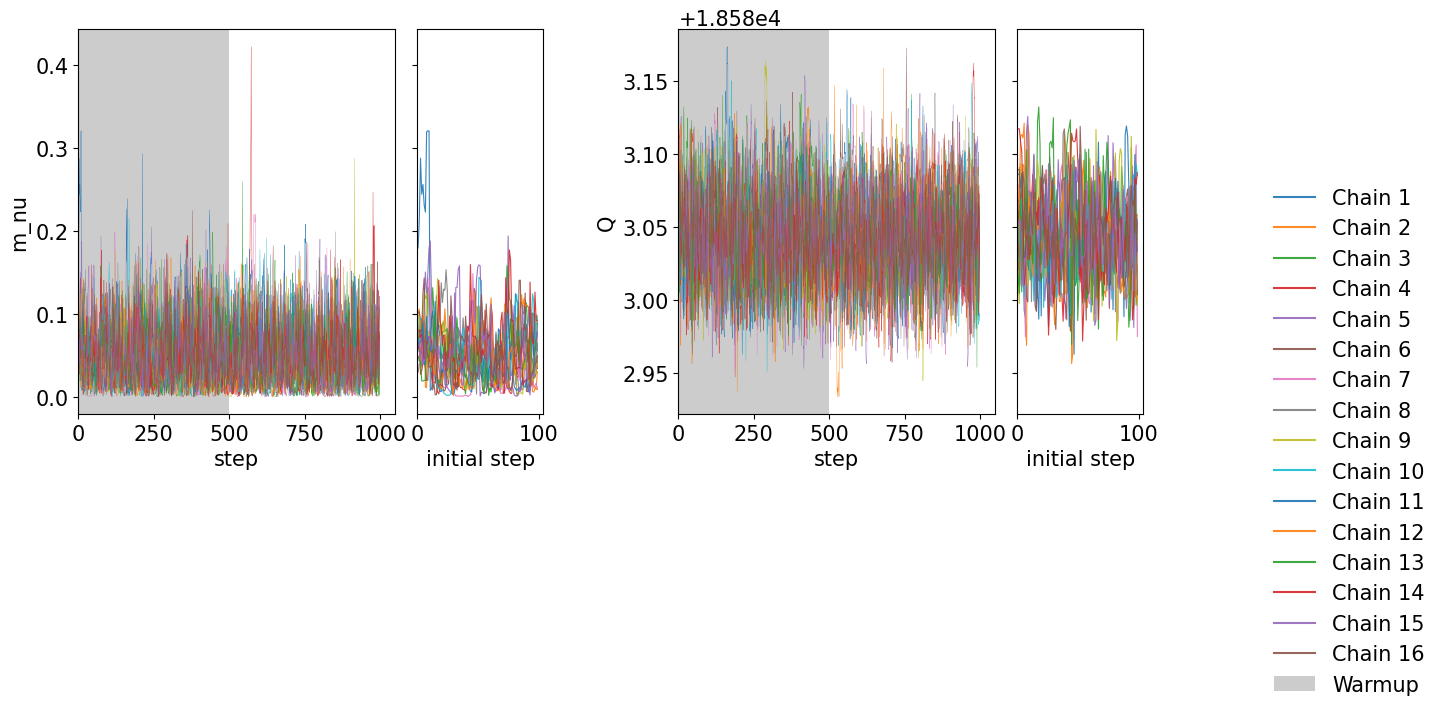


 ---- Posterior predictive check ---- 



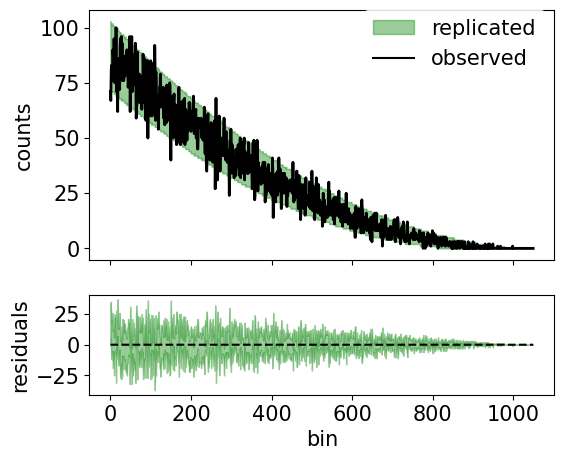


 ---- Posterior distributions ---- 



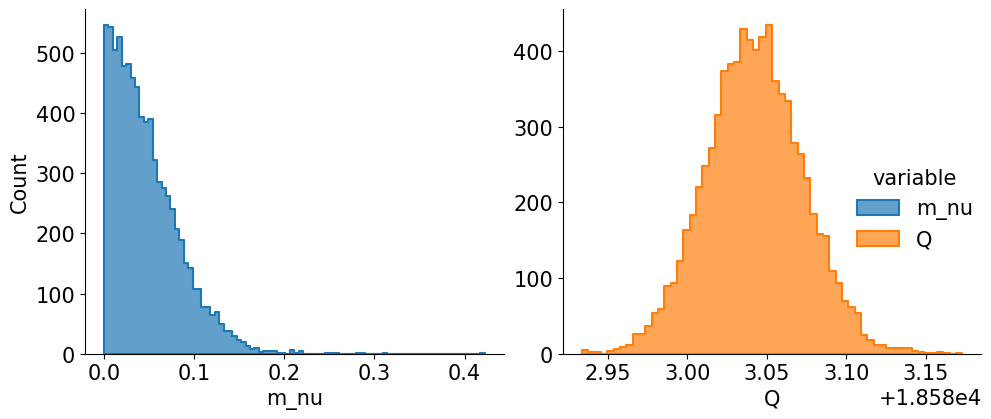


 ---- Prior vs posterior comparison ---- 



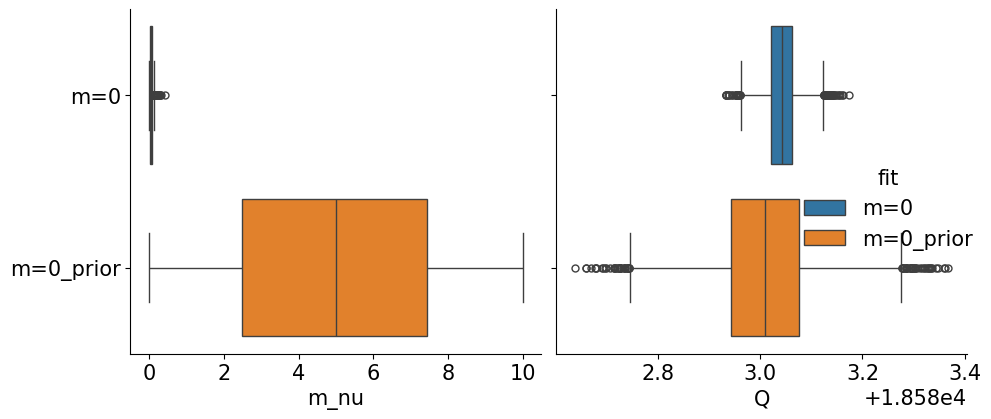

In [19]:
model = get_model("beta_endpoint.stan")
sampler_kwargs={
    'chains': 16,
    'iter_warmup': 500,
    'iter_sampling': 500,
    'save_warmup': True,
    'adapt_delta': 0.9,
    "sig_figs": 10,
    "show_console": False,
    "inits": {"m_red": 0.01, "z": 0}
}
plot_pars = ['m_nu', 'Q']
p = FitPlotter(col_wrap=4)
fit_noQs = standard_analysis(model, data, p, sampler_kwargs, fit_title='m=0', plot_params = plot_pars)

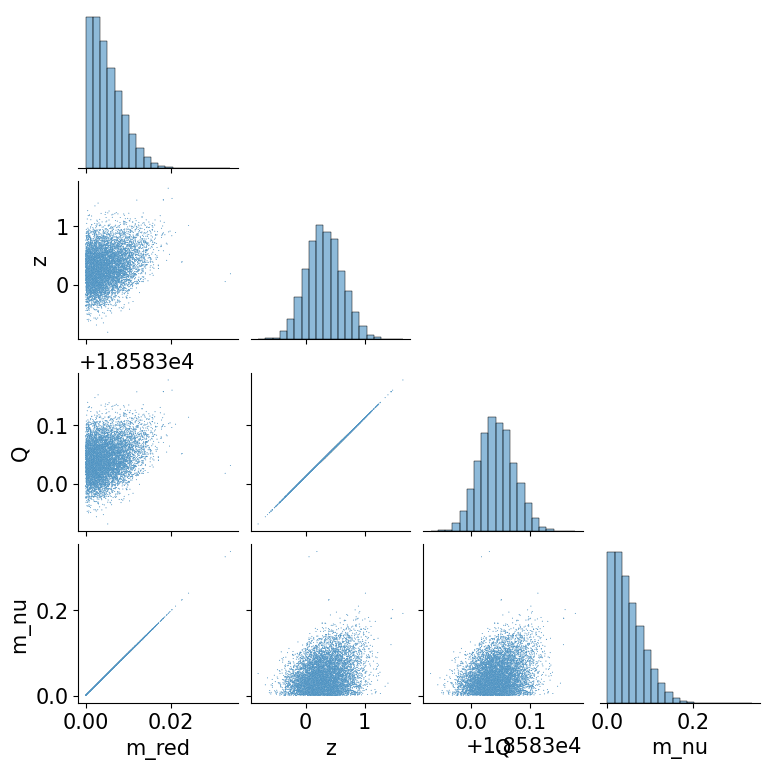

In [18]:
p.pair_grid()